# 検証に使う関数準備

In [1]:
import pandas as pd
import numpy as np
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy import stats


%matplotlib inline

from sklearn.preprocessing import StandardScaler

In [2]:
def cards(deck = 2) -> pd.DataFrame:
    #カードをシャッフルする関数
    
    cards_df = pd.DataFrame(np.zeros(deck * 104).reshape(deck * 52,2),columns=["mark","num"])
    cards_number = ["A","2","3","4","5","6","7","8","9","10","J","Q","K"] * 4 * deck
    cards_mark = ["heart","spade","clob","diamond"] * 13 * deck

    #デッキの数分マークとナンバーを入れる
    for i in range(52 * deck):
        cards_df.iloc[i] = cards_mark[i]
        cards_df["num"].iloc[i] = cards_number[i]

    cards = cards_df.sample(n =len(cards_df))
    cards = cards.reset_index(drop=True)

    return cards

In [3]:
def hand_calc(hand) -> int:
    #今の手札の合計を数える関数
    hand_df = hand.loc[hand["num"] != 0][["num"]]
    #まずはナンバーと、ピクチャーと、エースの分類を分ける
    number = ["2","3","4","5","6","7","8","9","10"]
    picture = ["J","Q","K"]
    Ace = ["A"]

    #ピクチャーを10に置き換えて、合計
    picture_hand = hand_df.loc[hand_df["num"].isin(picture)].copy()
    for pict in range(len(picture_hand)):
        picture_hand.iloc[pict] = 10
    picture_hand_int = picture_hand.sum()

    #ナンバーをそのままint型へ変えて、合計
    int_hand = hand_df.loc[hand_df["num"].isin(number)].astype(int).sum()

    #ナンバーとピクチャーの合計をとる
    hand = picture_hand_int + int_hand
    hand = int(hand)

    #エースの処理

    #エースが最大の時と最小で比較する
    Ace_hand = hand_df.loc[hand_df["num"].isin(Ace)].copy()
    Ace_max = Ace_hand.count() * 11 + hand
    Ace_min = Ace_hand.count() * 1 + hand

    #エースを最大としてとったらバーストするが、最小としてとったらバーストしない場合にエースを処理する
    for a in range(len(Ace_hand)):
        Ace_hand.iloc[a] = 11

    if Ace_max.iloc[0] > 21 and Ace_min.iloc[0] <= 21:
        num = 0
        while Ace_max.iloc[0] > 21:
            Ace_hand.iloc[num] = 1
            Ace_max = Ace_hand.sum() + hand
            num = num + 1


    hand_sum = Ace_max.iloc[0]

    return hand_sum


In [4]:
class Cpu():
    #cpuの操作をひとまとめにしたクラス
    #cpu1はベーシックストラテジー通りに、同じ金額を賭ける
    #pcu3はベーシックストラテジー通りに戦って、カウンティングの大きさに応じて賭ける金額を変える
    #cpu2はベーシックストラテジー通りに戦って、モンテカルロ法で賭ける金額を変える

    def playingcpu_set(self,dealer,player):
        self.dealer = dealer
        self.player = player

    def bettingcpu_set(self,field):
        self.field = field

    def chip_win_set(self,monte_table,win_flag):
        self.winflag = win_flag
        self.monte_table = monte_table

    def monte_carlo(self) -> pd.DataFrame:
        #モンテカルロ法メソッド
        win_flag = self.winflag
        all_chip  = self.monte_table
        start = 0
        last = len(all_chip)-1

        if win_flag == 0:
            next_chip = pd.DataFrame([int(all_chip.iloc[start]) + int(all_chip.iloc[last])],columns=["count"])
            all_chip = pd.concat([all_chip,next_chip],ignore_index=True)
            
        elif win_flag == 1 or win_flag == 21:
            all_chip.drop([start,last],inplace = True)
            all_chip = all_chip.reset_index(drop = True)

            if len(all_chip) <= 1:
                all_chip = pd.DataFrame([1,2,3],columns=["count"])


        return all_chip


    def counting(self) -> int:
        #フィールド上で今まで出てきたカードを数えるメソッド
        field = self.field
        new_hand_log = field[["num"]].copy()

        #フィールド上のカードを全て数字に置き換える
        for i in range(len(field)):
            hand_num = hand_calc(field.iloc[[i]])
            new_hand_log.iloc[i] = hand_num
        
        high_hand = new_hand_log.loc[new_hand_log["num"] >= 10]
        mid_hand = new_hand_log.loc[(new_hand_log["num"] >= 7)&(new_hand_log["num"] <=9)]
        low_hand = new_hand_log.loc[new_hand_log["num"]  <= 6]

        counting = (high_hand.count() * (-1)) + low_hand.count()
        counting = counting.iloc[-1]
        
        return counting



    def basic_st(self) -> int:
        #ベーシックストラテジーのメソッド
        cpu_df = self.player
        cpu_df = cpu_df.loc[cpu_df["num"] != 0][["num"]]
        cpu_calc = hand_calc(cpu_df)

        dealer_df = self.dealer
        dealer_df = dealer_df.loc[dealer_df["num"] != 0][["num"]]
        dealer_calc = hand_calc(dealer_df)


        #ソフトハンド
        if cpu_df.isin(["A"]).any().bool() and len(cpu_df) == 2:
            if cpu_calc >= 19:
                judge = 0
            elif cpu_calc == 18 and dealer_calc == 2:
                judge = 0
            elif cpu_calc == 18 and 7 <= dealer_calc <= 8:
                judge = 0

            elif cpu_calc == 18 and 3 <= dealer_calc <= 4:
                judge = 2
            elif cpu_calc == 17 and 3 <= dealer_calc <= 4:
                judge = 2
            elif 15 <= cpu_calc <= 16 and dealer_calc == 4:
                judge = 2
            elif 13 <= cpu_calc <= 18 and 5 <= dealer_calc <= 6:
                judge = 2
                
            elif cpu_calc == 18 and 9 <= dealer_calc <= 11:
                judge = 1
            elif cpu_calc == 17 and dealer_calc == 2:
                judge = 1
            elif 13 <= cpu_calc <= 16 and 2 <= dealer_calc <= 3:
                judge = 1
            elif 13 <= cpu_calc <= 14 and dealer_calc == 4:
                judge = 1
            elif 13 <= cpu_calc <= 17 and 7 <= dealer_calc <= 11:
                judge = 1

            #今回はダブルスプリット未実装のため、もしAAの時は実質的にハードハンド
            elif cpu_calc == 12 and 2 <= dealer_calc <= 3:
                judge = 1
            elif cpu_calc == 12 and 4 <= dealer_calc <= 6:
                judge = 0
            elif cpu_calc == 12 and 7 <= dealer_calc <= 11:
                judge = 1
                
        #ハードハンド
        else:
            if cpu_calc <= 8:
                judge = 1
            elif cpu_calc == 9 and dealer_calc == 2:
                judge = 1
            elif cpu_calc == 9 and 7 <= dealer_calc <= 11:
                judge = 1
            elif cpu_calc == 10 and 10 <= dealer_calc <= 11:
                judge = 1
            elif cpu_calc == 11 and dealer_calc == 11:
                judge = 1

            elif 9 <= cpu_calc <= 11 and 3 <= dealer_calc <= 6:
                judge = 2
            elif 10 <= cpu_calc <= 11 and 7 <= dealer_calc <= 9:
                judge  = 2
            elif cpu_calc == 11 and dealer_calc ==10:
                judge = 2
            elif 10 <= cpu_calc <= 11 and dealer_calc == 2:
                judge = 2

            elif cpu_calc == 12 and dealer_calc >= 7:
                judge = 1
            elif cpu_calc == 12 and 4 <= dealer_calc <= 6:
                judge = 0
            elif cpu_calc == 12 and dealer_calc <= 3:
                judge = 1
            
            elif 13  <= cpu_calc <= 14 and 7 <= dealer_calc <= 11:
                judge = 1
            elif 15 <= cpu_calc <= 16 and 7 <= dealer_calc <= 8:
                judge = 1
            elif cpu_calc == 15 and dealer_calc == 9:
                judge = 1
            elif cpu_calc == 15 and dealer_calc == 11:
                judge = 1

            elif cpu_calc == 15 and dealer_calc == 10:
                judge = 1
            elif cpu_calc == 16 and 9 <= dealer_calc  <= 11:
                judge = 1
            elif 13 <= cpu_calc <= 16 and 2 <= dealer_calc <= 6:
                judge = 0
            elif 15 <= cpu_calc <= 16 and 7 <= dealer_calc <= 8:
                judge = 1
            elif cpu_calc >= 17:
                judge = 0

        return judge
    

    def high_count_st(self):
        #トゥルーカウントが高い時のメソッド
        cpu_df = self.player
        cpu_df = cpu_df.loc[cpu_df["num"] != 0][["num"]]
        cpu_calc = hand_calc(cpu_df)

        dealer_df = self.dealer
        dealer_df = dealer_df.loc[dealer_df["num"] != 0][["num"]]
        dealer_calc = hand_calc(dealer_df)

        if cpu_df.isin(["A"]).any().bool() and len(cpu_df) == 2:
            #ソフトハンド
            if cpu_calc >= 20:
                judge = 0
            elif cpu_calc == 19 and 2 <= dealer_calc <= 3:
                judge = 0
            elif cpu_calc == 19 and 4 <= dealer_calc <= 6:
                judge = 2
            elif cpu_calc == 19 and 7 <= dealer_calc <= 11:
                judge = 0
            elif 17 <= cpu_calc <= 18 and 2 <= dealer_calc <= 6:
                judge = 2
            elif cpu_calc == 18 and 7 <= dealer_calc <= 8:
                judge = 0
            elif cpu_calc == 18 and 9 <= dealer_calc <= 10:
                judge = 1
            elif cpu_calc == 18 and dealer_calc == 11:
                judge = 0
            elif 13 <= cpu_calc <= 16 and dealer_calc == 2:
                judge = 1
            elif 13 <= cpu_calc <= 15 and dealer_calc == 3:
                judge = 1
            elif cpu_calc == 16 and dealer_calc == 3:
                judge = 2
            elif 13 <= cpu_calc <= 16 and 4 <= dealer_calc <= 6:
                judge = 2
            elif 13 <= cpu_calc <= 17 and 7 <= dealer_calc <= 11:
                judge = 1

            #ダブルスプリット未実装のため、AAはハードハンドとして扱う
            elif cpu_calc == 12 and 2 <= dealer_calc <= 6:
                judge = 0
            elif cpu_calc == 12 and 7 <= dealer_calc <= 11:
                judge = 1
        else:
            #ハードハンド
            if cpu_calc <= 7:
                judge = 1
            elif cpu_calc == 8 and 2 <= dealer_calc <= 4:
                judge = 1
            elif cpu_calc == 8 and 5 <= dealer_calc <= 6:
                judge = 2
            elif cpu_calc == 8 and 7 <= dealer_calc <= 11:
                judge = 1
            elif 9 <= cpu_calc <= 11 and 2 <= dealer_calc <= 7:
                judge = 2
            elif cpu_calc == 9 and 8 <= dealer_calc <= 11:
                judge = 1
            elif 10 <= cpu_calc <= 11 and 8 <= dealer_calc <= 9:
                judge = 2
            elif cpu_calc == 10 and 10 <= dealer_calc <= 11:
                judge = 1
            elif cpu_calc == 11 and 10 <= dealer_calc <= 11:
                judge = 2
            elif 12 <= cpu_calc <= 16 and 2 <= dealer_calc <= 6:
                judge = 0
            elif 12 <= cpu_calc <= 16 and 7 <= dealer_calc <= 9:
                judge = 1
            elif 12 <= cpu_calc <= 14 and 10 <= dealer_calc <= 11:
                judge = 1
            elif 15 <= cpu_calc <= 16 and dealer_calc == 10:
                judge = 0
            elif 15 <= cpu_calc <= 16 and dealer_calc == 11:
                judge = 1
            elif cpu_calc >= 17:
                judge = 0

        return judge



In [5]:
def black_jack(syoki_chip = 1000,deck = 2):
    #ディーラーとプレイヤーのデータフレームの用意
    df_dealer = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
    df_player = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
    hand_log = pd.DataFrame(columns=["mark","num"])
    df_chip = pd.DataFrame([syoki_chip],index=["player"],columns=["chip"])


    #カードデッキの作成
    playing_cards = cards(deck=deck)
    card_count = 0
    rest_deck = len(playing_cards) - card_count
    sarender = pd.DataFrame([["heart","K"],["heart","K"],["heart","K"]],columns=["mark","num"])
    
    #bet金額を聞く
    bet = input("いくらかけますか？今{}です。".format(df_chip.iloc[0]))
    bet = int(bet)
    chip_sum = df_chip.sum().iloc[-1]


    while chip_sum > 0 and rest_deck > 10:
        df_chip.iloc[0] = df_chip.iloc[0] - bet
        
        #ディーラーとプレイヤーにカードを配る
        df_dealer.iloc[0] = playing_cards.iloc[card_count]
        hand_log = pd.concat([hand_log,playing_cards.iloc[[card_count]]])
        card_count = card_count + 1

        df_player.iloc[0] = playing_cards.iloc[card_count]
        hand_log = pd.concat([hand_log,playing_cards.iloc[[card_count]]])
        card_count = card_count + 1

        df_player.iloc[1] = playing_cards.iloc[card_count]
        hand_log = pd.concat([hand_log,playing_cards.iloc[[card_count]]])
        card_count = card_count + 1

        judge = 1
        num = 2
        #プレイヤーのジャッジが１より大きい間継続
        while judge > 0:

            #現在のフィールドの情報を提供
            display("ディーラーのハンドは:",df_dealer.iloc[[0]])
            display("あなたのハンドは:",df_player.loc[df_player["num"] != 0])

            print("現在ディーラーは",hand_calc(df_dealer),"現在あなたは",hand_calc(df_player))
            
            #プレイヤーにヒットするかどうか判断させる
            judge = int(input("ヒットなら1、ダブルダウンは2、サレンダーは3表示されてなかったら10,スタンドなら0。(ダブルダウンの場合の残りチップ{})".format(df_chip.iloc[0]-bet)))

            if judge == 1:
                #ヒットなら、プレイヤーにカードを一枚配る
                df_player.iloc[num] = playing_cards.iloc[card_count]
                hand_log = pd.concat([hand_log,playing_cards.iloc[[card_count]]])
                card_count = card_count + 1

            elif judge == 2:
                df_chip.iloc[0] = df_chip.iloc[0] - bet
                #ダブルダウンなら、チップからもう一度賭け金を引いて、betにbetの二倍を再代入する
                bet = bet * 2
                df_player.iloc[num] = playing_cards.iloc[card_count]
                hand_log = pd.concat([hand_log,playing_cards.iloc[[card_count]]])
                card_count = card_count + 1
                judge = 0
            elif judge == 3:
                df_chip.iloc[0] = df_chip.iloc[0] + (bet/2)
                df_player = pd.concat([df_player,sarender])
                judge = 0
            elif judge == 10:
                #うまく表示できなかった時に、フィールド情報を再表示する
                print("現在ディーラーは",hand_calc(df_dealer),"現在あなたは",hand_calc(df_player))
            num = num + 1

            clear_output()
            #バースト判定
            if hand_calc(df_player) >= 22:
                print("バーストしました")
                judge = 0


        #ディーラーのターン（もしプレイヤーがバーストしてたら、その時点で終了）
        if hand_calc(df_player) < 22:
            num = 1
            #ディーラーの手札が合計17まで続ける
            while hand_calc(df_dealer) < 17:
                df_dealer.iloc[num] = playing_cards.iloc[card_count]
                hand_log = pd.concat([hand_log,playing_cards.iloc[[card_count]]])
                card_count = card_count + 1

                print("現在ディーラーは",hand_calc(df_dealer),"現在あなたは",hand_calc(df_player))
                num = num + 1

            #勝敗判定
            if hand_calc(df_dealer) > 21:
                print("you win")
                df_chip.iloc[0] = df_chip.iloc[0] + bet * 2
            elif hand_calc(df_dealer) - hand_calc(df_player) > 0:
                print("you lost")

            elif hand_calc(df_dealer) - hand_calc(df_player) <= 0:
                print("you win")
                df_chip.iloc[0] = df_chip.iloc[0] + bet * 2

        df_dealer = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
        df_player = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])


        bet = input("いくらかけますか？今{}です。終了したい場合はfinを入力してください。".format(df_chip.iloc[0]))
        if bet == "fin":
            break
        bet = int(bet)
        chip_sum = df_chip.sum().iloc[-1]
        rest_deck = len(playing_cards) - card_count
    return df_chip

In [135]:
black_jack(syoki_chip=1000)

現在ディーラーは 12 現在あなたは 10
現在ディーラーは 12 現在あなたは 10
現在ディーラーは 18 現在あなたは 10
you lost


,chip
player,750


# それぞれのcpuが別々にプレイした場合

In [106]:
def black_jack_nonplayer(syoki_chip = 1000,deck = 2,standard_bet = 100,sesion = 20):
    #ディーラーとプレイヤーのデータフレームの用意
    df_dealer = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
    df_cpu_1 = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
    df_cpu_2 = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
    df_cpu_3 = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])

    sarender = pd.DataFrame([["heart","K"],["heart","K"],["heart","K"]],columns=["mark","num"])


    df_chip = pd.DataFrame(columns=["chip"])
    for member in range(1,4):
        cpu = pd.DataFrame([syoki_chip],index=["cpu_{}".format(member)],columns=["chip"])
        df_chip = pd.concat([df_chip,cpu])

    #カードデッキの作成
    playing_cards = cards(deck=deck)
    card_count = 0
    rest_deck = len(playing_cards) - card_count
    
    #bet金額を聞く
    bet_cpu1 = standard_bet
    bet_cpu2 = standard_bet
    bet_cpu3 = standard_bet

    #bet金額を持ちチップから減らす。
    df_chip.iloc[0] -= bet_cpu1
    df_chip.iloc[1] -= bet_cpu2
    df_chip.iloc[2] -= bet_cpu3
    
    #モンテカルロ法のセット
    monte_df = pd.DataFrame([1,2,3],columns=["count"])

    #プレイ回数をカウントする。プレイ回数が指定したセッション数を超えるとプレイが終了する。
    play_count = 1
    
    #参加するかどうか聞くデータフレーム
    join  = pd.DataFrame([1,1,1],columns=["join"],index=["cpu1","cpu2","cpu3"])

    #cpu１と２の勝利を数えるためのデータフレームを用意。負けたら０、勝ったら１、ドローなら２を記録する.
    win_log_1 = pd.DataFrame(np.zeros(200),columns=["win_flag"])
    win_log_2 = pd.DataFrame(np.zeros(200),columns=["win_flag"])
    win_log_3 = pd.DataFrame(np.zeros(200),columns=["win_flag"])

    #cpuのカウンティングと勝利を記録する
    counting_log = pd.DataFrame(columns=['counting_log'])
    chip_log1 = pd.DataFrame(columns=["chip"])
    chip_log2 = pd.DataFrame(columns=["chip"])
    chip_log3 = pd.DataFrame(columns=["chip"])

    #プレイ開始。参加者が０になるか、前もって指定したセッション数を超えると終了する.
    while int(join.loc[join["join"] == 1].count()) >= 1 and play_count < sesion + 1:

        #ディーラーとプレイヤーにカードを配る
        df_dealer.iloc[0] = playing_cards.iloc[card_count]
        card_count = card_count + 1


        ##
        ##各CPUについて、それぞれのプレイ部分をパラメータの中で操作するために分けずに一つの関数に入れる。
        ##

        #cpu１のプレイ
        if int(join.iloc[0]) > 0:
            df_cpu_1.iloc[0] = playing_cards.iloc[card_count]
            card_count += 1
            df_cpu_1.iloc[1] = playing_cards.iloc[card_count]
            card_count += 1

            judge = 1
            num = 2
            while judge > 0:

                #現在のフィールドの情報を提供
                cpu1 = Cpu()
                cpu1.playingcpu_set(dealer=df_dealer.iloc[[0]],player = df_cpu_1)
                judge = cpu1.basic_st()


                if judge == 1:
                    #ヒットなら、cpuにカードを一枚配る
                    df_cpu_1.iloc[num] = playing_cards.iloc[card_count]
                    card_count = card_count + 1

                elif judge == 2:
                    df_chip.iloc[0] -= bet_cpu1
                    #ダブルダウンなら、チップからもう一度賭け金を引いて、betにbetの二倍を再代入する
                    bet_cpu1 = bet_cpu1 * 2
                    df_cpu_1.iloc[num] = playing_cards.iloc[card_count]
                    card_count = card_count + 1
                    judge = 0
                elif judge == 3:
                    #サレンダーしていたら、チップをベット金額の半分戻して、勝てない手札にする
                    df_chip.iloc[0] = df_chip.iloc[0] + (bet_cpu1/2)
                    df_cpu_1 = pd.concat([df_cpu_1,sarender])
                    judge = 0

                num = num + 1
                #バースト判定
                if hand_calc(df_cpu_1) >= 22:
                    judge = 0
                
        elif int(join.iloc[0]) <= 0:
            df_cpu_1 = pd.concat([df_cpu_1,sarender])


        #cpu2のプレイ
        if int(join.iloc[1]) > 0:
            df_cpu_2.iloc[0] = playing_cards.iloc[card_count]
            card_count += 1
            df_cpu_2.iloc[1] = playing_cards.iloc[card_count]
            card_count += 1

            judge = 1
            num = 2
            while judge > 0:


                #現在のフィールドの情報を提供
                cpu2 = Cpu()
                cpu2.playingcpu_set(dealer=df_dealer.iloc[[0]],player = df_cpu_2)
                judge = cpu2.basic_st()


                if judge == 1:
                    #ヒットなら、cpuにカードを一枚配る
                    df_cpu_2.iloc[num] = playing_cards.iloc[card_count]
                    card_count = card_count + 1

                elif judge == 2:
                    df_chip.iloc[1] -= bet_cpu2
                    #ダブルダウンなら、チップからもう一度賭け金を引いて、betにbetの二倍を再代入する
                    bet_cpu2 = bet_cpu2 * 2
                    df_cpu_2.iloc[num] = playing_cards.iloc[card_count]
                    card_count = card_count + 1
                    judge = 0
                elif judge == 3:
                    #サレンダーしていたら、チップをベット金額の半分戻して、勝てない手札にする
                    df_chip.iloc[1] += bet_cpu2 / 2
                    df_cpu_2 = pd.concat([df_cpu_2,sarender])
                    judge = 0

                num = num + 1
                #バースト判定
                if hand_calc(df_cpu_2) >= 22:
                    judge = 0
                
        elif int(join.iloc[1]) <= 0:
            df_cpu_2 = pd.concat([df_cpu_2,sarender])


        #cpu3のプレイ
        if int(join.iloc[2]) > 0:
            df_cpu_3.iloc[0] = playing_cards.iloc[card_count]
            card_count += 1
            df_cpu_3.iloc[1] = playing_cards.iloc[card_count]
            card_count += 1

            judge = 1
            num = 2
            while judge > 0:

                #現在のフィールドの情報を提供
                hand_log = playing_cards.iloc[:card_count]
                cpu3 = Cpu()
                cpu3.bettingcpu_set(hand_log)
                counting = cpu3.counting() / ((len(playing_cards)-card_count)/52)
                cpu3.playingcpu_set(dealer=df_dealer.iloc[[0]],player=df_cpu_3)
                if counting < 3:
                    judge = cpu3.basic_st()
                else:
                    judge = cpu3.high_count_st()

                if judge == 1:
                    #ヒットなら、cpuにカードを一枚配る
                    df_cpu_3.iloc[num] = playing_cards.iloc[card_count]                    
                    card_count = card_count + 1

                elif judge == 2:
                    df_chip.iloc[2] -= bet_cpu3
                    #ダブルダウンなら、チップからもう一度賭け金を引いて、betにbetの二倍を再代入する
                    bet_cpu3 = bet_cpu3 * 2

                    df_cpu_3.iloc[num] = playing_cards.iloc[card_count]                    
                    card_count = card_count + 1
                    judge = 0
                elif judge == 3:
                    #サレンダーしていたら、チップをベット金額の半分戻して、勝てない手札にする
                    df_chip.iloc[2] = df_chip.iloc[2] + (bet_cpu3/2)
                    df_cpu_3 = pd.concat([df_cpu_3,sarender])
                    judge = 0

                num = num + 1
                #バースト判定
                if hand_calc(df_cpu_3) >= 22:
                    judge = 0
        elif int(join.iloc[2]) <= 0:
            df_cpu_3 = pd.concat([df_cpu_3,sarender])




        #ディーラーのターン（もし全プレイヤーがバーストしてたら、その時点で終了）
        if hand_calc(df_cpu_1) < 22 or hand_calc(df_cpu_2) < 22 or hand_calc(df_cpu_3) < 22:
            num = 1
            #ディーラーの手札が合計17まで続ける
            while hand_calc(df_dealer) < 17:
                df_dealer.iloc[num] = playing_cards.iloc[card_count]
                card_count = card_count + 1
                num = num + 1

            #バーストしてなかったプレイヤーの勝利判定
            if hand_calc(df_cpu_1) < 22:
                if hand_calc(df_cpu_1) == 21 and len(df_cpu_1.loc[df_cpu_1["num"] != 0]) == 2:
                    df_chip.iloc[0] += bet_cpu1 * 2.5
                    win_log_1.iloc[play_count-1] = 21
                elif hand_calc(df_dealer) >= 22:
                    df_chip.iloc[0] += bet_cpu1 * 2
                    win_log_1.iloc[play_count-1] = 1
                elif hand_calc(df_dealer) < hand_calc(df_cpu_1):
                    df_chip.iloc[0] += bet_cpu1 * 2
                    win_log_1.iloc[play_count-1] = 1
                elif hand_calc(df_dealer) == hand_calc(df_cpu_1):
                    df_chip.iloc[0] += bet_cpu1
                    win_log_1.iloc[play_count-1] = 2

            if hand_calc(df_cpu_2) < 22:
                if hand_calc(df_cpu_2) == 21 and len(df_cpu_2.loc[df_cpu_2["num"] != 0]) == 2:
                    df_chip.iloc[1] += bet_cpu2 * 2.5
                    win_log_2.iloc[play_count-1] = 21
                elif hand_calc(df_dealer) >= 22:
                    df_chip.iloc[1] += bet_cpu2 * 2
                    win_log_2.iloc[play_count-1] = 1
                elif hand_calc(df_dealer) < hand_calc(df_cpu_2):
                    df_chip.iloc[1] += bet_cpu2 * 2
                    win_log_2.iloc[play_count-1] = 1
                elif hand_calc(df_dealer) == hand_calc(df_cpu_2):
                    df_chip.iloc[1] += bet_cpu2
                    win_log_2.iloc[play_count-1] = 2

            if hand_calc(df_cpu_3) < 22:
                if hand_calc(df_cpu_3) == 21 and len(df_cpu_3.loc[df_cpu_3["num"] != 0]) == 2:
                    df_chip.iloc[2] += bet_cpu3 * 2.5
                    win_log_3.iloc[play_count-1] = 21
                elif hand_calc(df_dealer) >= 22:
                    df_chip.iloc[2] += bet_cpu3 * 2
                    win_log_3.iloc[play_count-1] = 1
                elif hand_calc(df_dealer) < hand_calc(df_cpu_3):
                    df_chip.iloc[2] += bet_cpu3 * 2
                    win_log_3.iloc[play_count-1] = 1
                elif hand_calc(df_dealer) == hand_calc(df_cpu_3):
                    df_chip.iloc[2] += bet_cpu3
                    win_log_3.iloc[play_count-1] = 2


        bet_cpu1 = standard_bet

        #モンテカルロcpuの次のベット金額を設定する
        monte_carlo_cpu = Cpu()
        monte_carlo_cpu.chip_win_set(monte_table=monte_df,win_flag=int(win_log_2.iloc[play_count-1]))
        monte_df = monte_carlo_cpu.monte_carlo()
        bet_cpu2 = (int(monte_df.iloc[0]) + int(monte_df.iloc[len(monte_df) - 1])) * (standard_bet/8)
        

        #カウンティングcpuの次のベット金額を設定する
        hand_log = playing_cards.iloc[:card_count]
        counting_cpu = Cpu()
        counting_cpu.bettingcpu_set(hand_log)
        counting = counting_cpu.counting() / ((len(playing_cards)-card_count)/52)
        
        if -1 <= counting <= 1:
            bet_cpu3 = standard_bet
        elif counting > 1:
            bet_cpu3 = standard_bet * 2
        elif counting < -1:
            bet_cpu3 = standard_bet / 2

        #カウンティング状況を記録
        counting_thistime = pd.DataFrame([counting],columns=['counting_log'])
        counting_log = pd.concat([counting_log,counting_thistime],ignore_index=True)

        #チップの推移を記録
        chip_log1 = pd.concat([chip_log1,df_chip.iloc[[0]]],ignore_index=True)
        chip_log2 = pd.concat([chip_log2,df_chip.iloc[[1]]],ignore_index=True)
        chip_log3 = pd.concat([chip_log3,df_chip.iloc[[2]]],ignore_index=True)

        #手札のリセット
        df_dealer = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
        df_cpu_1 = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
        df_cpu_2 = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
        df_cpu_3 = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])


        #山札が減っていたら補給
        rest_deck = len(playing_cards) - card_count
        if rest_deck < 15:
            playing_cards = cards(deck=deck)
            card_count = 0
            hand_log = pd.DataFrame(columns=["mark","num"])

        play_count += 1

        #もしチップが０より大きいなら、ベットさせる
        if play_count < sesion:
            if int(df_chip.iloc[0]) - bet_cpu1 >= 0:
                df_chip.iloc[0] -= bet_cpu1
                join.iloc[0] = 1
            else:
                join.iloc[0] -= 1

            if int(df_chip.iloc[1]) - bet_cpu2 >= 0:
                df_chip.iloc[1] -= bet_cpu2
                join.iloc[1] = 1
            else:
                join.iloc[1] -= 1

            if int(df_chip.iloc[2]) - bet_cpu3 >= 0:
                join.iloc[2] = 1
                df_chip.iloc[2] -= bet_cpu3
            else:
                join.iloc[2] -= 1

    cpu1_chip = chip_log1
    cpu1_winflag = win_log_1.iloc[:len(cpu1_chip)]
    cpu1_data = cpu1_winflag.join([cpu1_chip])
    cpu1_data.columns = (["cpu1_winlose","cpu1_chip"])
    cpu2_chip = chip_log2
    cpu2_winflag = win_log_2.iloc[:len(cpu2_chip)]
    cpu2_data = cpu2_winflag.join([cpu2_chip])
    cpu2_data.columns = (["cpu2_winlose","cpu2_chip"])
    cpu3_chip = chip_log3
    cpu3_winflag = win_log_3.iloc[:len(cpu3_chip)]
    cpu3_data = cpu3_winflag.join([cpu3_chip])
    cpu3_data.columns = (["cpu3_winlose","cpu3_chip"])
    data = cpu1_data.join([cpu2_data,cpu3_data,counting_log])
    
    return df_chip,data

### 一回のプレイのデータを見る

,cpu1_winlose,cpu1_chip,cpu2_winlose,cpu2_chip,cpu3_winlose,cpu3_chip,counting_log
0,1.0,11000,1.0,12000,1.0,11000,2.236559
1,1.0,12000,2.0,12000.0,0.0,7000,1.902439
2,1.0,13000,1.0,12500.0,1.0,9000,-1.424658
3,1.0,14000,21.0,13250.0,2.0,9000.0,-3.301587
4,1.0,15000,0.0,12750.0,1.0,10000.0,-2.080000
5,1.0,16000,0.0,12125.0,0.0,9500.0,-1.485714
6,0.0,15000,0.0,11375.0,0.0,9000.0,0.000000
7,1.0,16000,1.0,12250.0,1.0,10000.0,0.000000
8,0.0,14000,1.0,13125.0,1.0,11000.0,1.659574
9,0.0,13000,0.0,12250.0,0.0,9000.0,0.000000


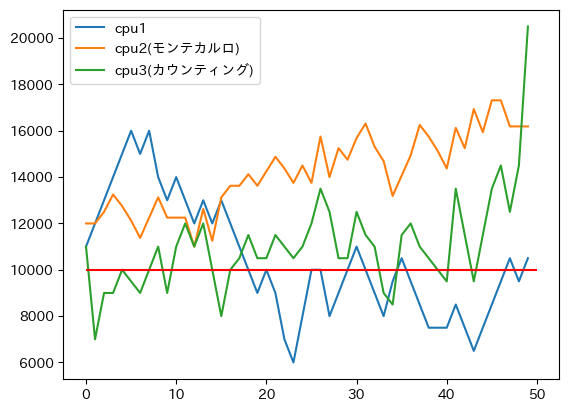

In [110]:
syoki = 10000
result = black_jack_nonplayer(syoki_chip=syoki,standard_bet=1000,sesion=50)

data = result[1]
display(data)
x = np.arange(len(data))
fig, ax = plt.subplots(facecolor="w")
ax.plot(x,data["cpu1_chip"].to_numpy() , label="cpu1")
ax.plot(x, data["cpu2_chip"].to_numpy(), label="cpu2(モンテカルロ)")
ax.plot(x,data["cpu3_chip"].to_numpy(),label = "cpu3(カウンティング)")
plt.hlines(syoki,0,len(data),colors="red")
ax.legend()
plt.show()

### 何回かプレイさせて、その推移をみる

0回目


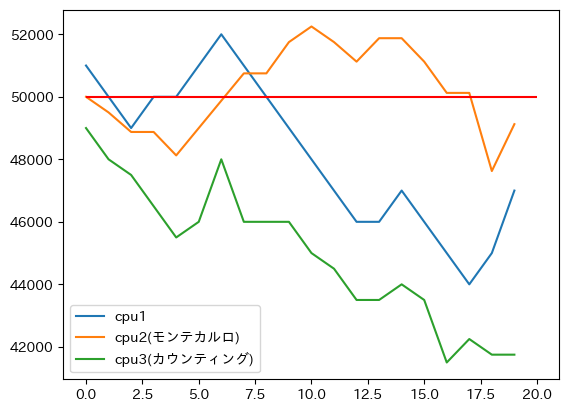

cpu1の勝率は: 0.35
cpu2の勝率は: 0.3
cpu3の勝率は: 0.2


,max-min
gamble_cpu1,8000.0


1回目


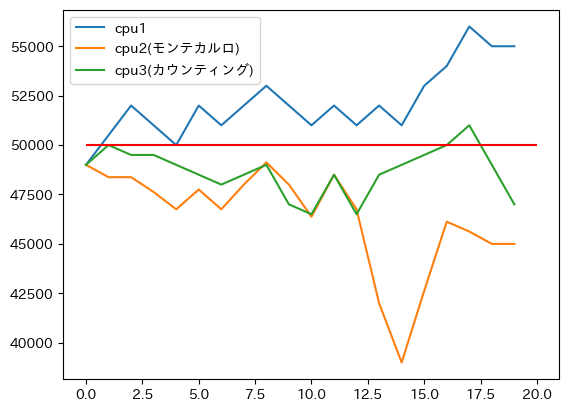

cpu1の勝率は: 0.5
cpu2の勝率は: 0.3
cpu3の勝率は: 0.45


,max-min
gamble_cpu2,10125.0


2回目


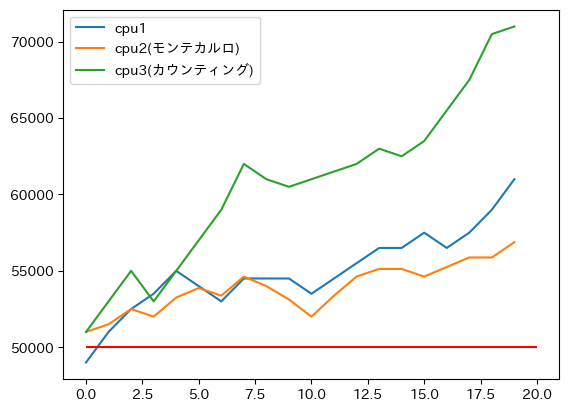

cpu1の勝率は: 0.6
cpu2の勝率は: 0.6
cpu3の勝率は: 0.75


,max-min
gamble_cpu3,20000.0


3回目


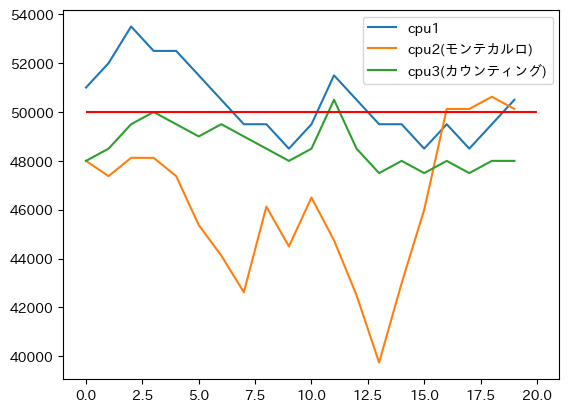

cpu1の勝率は: 0.35
cpu2の勝率は: 0.35
cpu3の勝率は: 0.45


,max-min
gamble_cpu2,10875.0


4回目


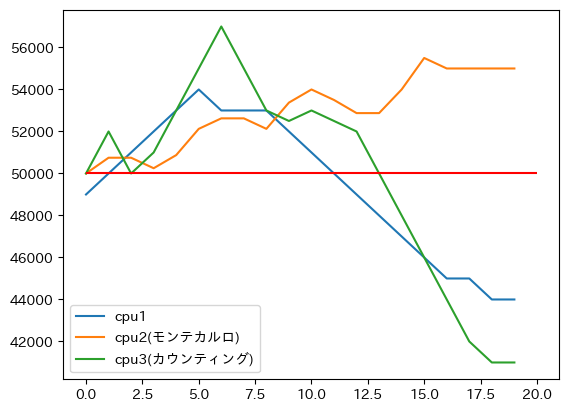

cpu1の勝率は: 0.25
cpu2の勝率は: 0.4
cpu3の勝率は: 0.3


,max-min
gamble_cpu3,16000.0


5回目


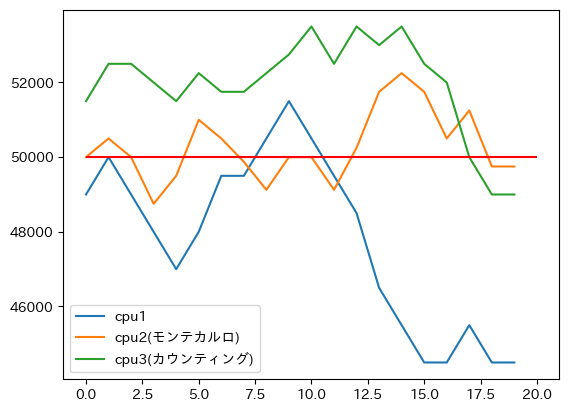

cpu1の勝率は: 0.3
cpu2の勝率は: 0.4
cpu3の勝率は: 0.4


,max-min
gamble_cpu1,7000.0


6回目


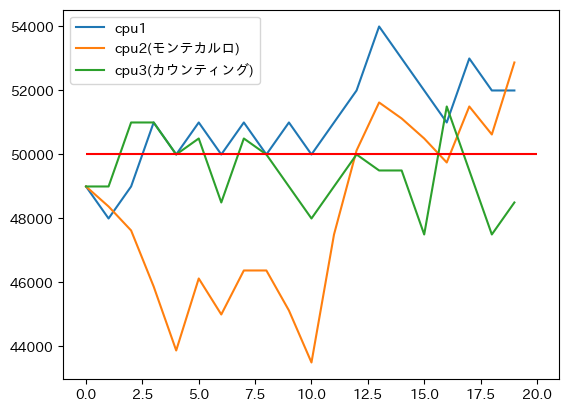

cpu1の勝率は: 0.45
cpu2の勝率は: 0.35
cpu3の勝率は: 0.3


,max-min
gamble_cpu2,9375.0


7回目


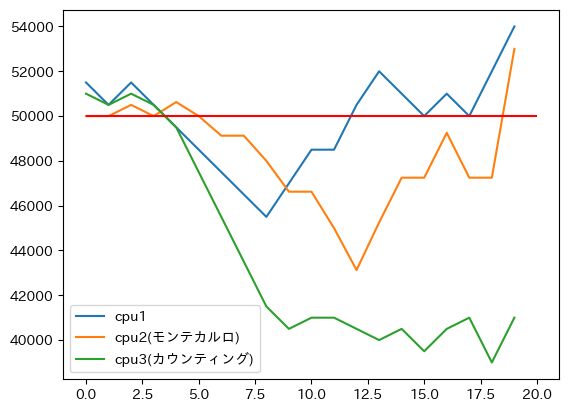

cpu1の勝率は: 0.45
cpu2の勝率は: 0.3
cpu3の勝率は: 0.35


,max-min
gamble_cpu3,12000.0


8回目


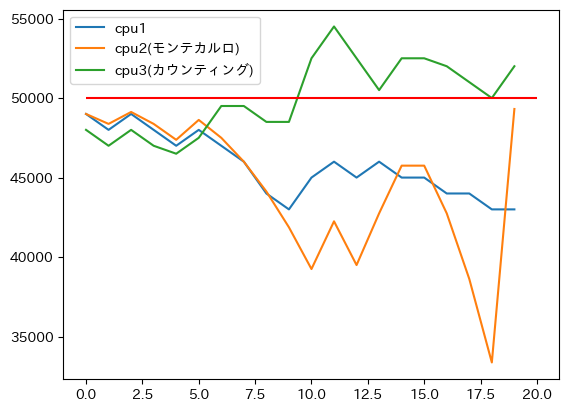

cpu1の勝率は: 0.25
cpu2の勝率は: 0.3
cpu3の勝率は: 0.35


,max-min
gamble_cpu2,15937.5


9回目


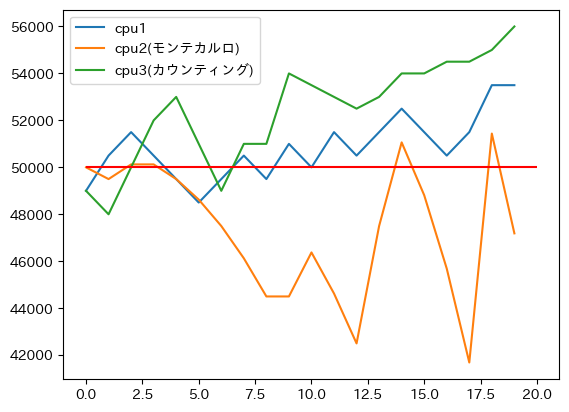

cpu1の勝率は: 0.5
cpu2の勝率は: 0.25
cpu3の勝率は: 0.45


,max-min
gamble_cpu2,9750.0


In [117]:
#チップの推移をプロットする
for i in range(10):
    syoki = 50000
    print("{}回目".format(i))
    result = black_jack_nonplayer(sesion=20,syoki_chip=syoki,standard_bet=1000)

    #データの整形
    data = result[1]
    
    #チップの推移の出力
    x = np.arange(len(data))
    fig, ax = plt.subplots(facecolor="w")
    ax.plot(x,data["cpu1_chip"].to_numpy() , label="cpu1")
    ax.plot(x, data["cpu2_chip"].to_numpy(), label="cpu2(モンテカルロ)")
    ax.plot(x,data["cpu3_chip"].to_numpy(),label = "cpu3(カウンティング)")
    plt.hlines(syoki,0,len(data),colors="red")
    ax.legend()
    plt.show()
    print("cpu1の勝率は:"
    ,data.loc[(data["cpu1_winlose"] == 1) | (data["cpu1_winlose"] == 21)]["cpu1_winlose"].count()/len(data))
    print("cpu2の勝率は:"
    ,data.loc[(data["cpu2_winlose"] == 1) | (data["cpu2_winlose"] == 21)]["cpu2_winlose"].count()/len(data))
    print("cpu3の勝率は:"
    ,data.loc[(data["cpu3_winlose"] == 1) | (data["cpu3_winlose"] == 21)]["cpu3_winlose"].count()/len(data))

    #最もギャンブル性が高いcpuを出力する  
    gamble_cpu1 = data["cpu1_chip"].max() - data["cpu1_chip"].min()
    gamble_cpu2 = data["cpu2_chip"].max() - data["cpu2_chip"].min()
    gamble_cpu3 = data["cpu3_chip"].max() - data["cpu3_chip"].min()
    df = pd.DataFrame([gamble_cpu1,gamble_cpu2,gamble_cpu3],index=["gamble_cpu1","gamble_cpu2","gamble_cpu3"],columns=["max-min"])
    display(df.sort_values(by=["max-min"],ascending=False).iloc[[0]])

### 何回かプレイさせて、その勝ち額を出力する

In [42]:
syoki = 50000
for i in range(5):
    if i  == 0:
        chip_result = pd.DataFrame(columns = ["cpu_1","cpu_2","cpu_3"])
    result = black_jack_nonplayer(syoki_chip=syoki,standard_bet=1000,sesion=50)
    
    chip_thistime = result[0].transpose() - syoki
    chip_thistime = chip_thistime.rename(index={"chip" : "{}回目勝ち額".format(i)})
    
    chip_result = pd.concat([chip_result,chip_thistime])

chip_result

,cpu_1,cpu_2,cpu_3
0回目勝ち額,-500.0,-8550.0,17250.0
1回目勝ち額,-7000,3250.0,5250.0
2回目勝ち額,3000.0,4800.0,-11250.0
3回目勝ち額,4500.0,9000.0,500.0
4回目勝ち額,-12500.0,8000.0,4500.0


In [54]:
#最初に持っているお金と、かけるお金にランダム性を持たせて観測を行う。
for i in range(50):
    if i  == 0:
        chip_result = pd.DataFrame(columns = ["cpu_1","cpu_2","cpu_3"])
        zyoukenn = pd.DataFrame(columns= ["syoki_chip","standardbet","session"])
        
    syoki = int(abs(np.random.normal(loc=10000,scale=5000)))
    standard = int(abs(np.random.normal(loc=1000,scale=250)))
    while standard > syoki:
        standard = int(abs(np.random.normal(loc=1000,scale=250)))

    session = int(abs(np.random.normal(loc = 50,scale=20)))


    result = black_jack_nonplayer(syoki_chip=syoki,standard_bet=standard,sesion=session)
    
    chip_thistime = result[0].transpose() - syoki
    chip_thistime = chip_thistime.rename(index={"chip" : "{}回目勝ち額".format(i+1)})
    zyoukenn_thistime = pd.DataFrame({"syoki_chip": [syoki], "standardbet": [standard], "session": [session]},index=["{}回目".format(i + 1)])



    zyoukenn = pd.concat([zyoukenn,zyoukenn_thistime])
    chip_result = pd.concat([chip_result,chip_thistime])


chip_result = chip_result.astype(int)
zyoukenn = zyoukenn.astype(int)

In [42]:
#かける金額にランダム性を持たせて行う。最初に持てるお金は固定。
syoki = 10000
for i in range(50):
    if i  == 0:
        chip_result = pd.DataFrame(columns = ["cpu_1","cpu_2","cpu_3"])
        zyoukenn = pd.DataFrame(columns= ["syoki_chip","standardbet","session"])
        

    standard = int(abs(np.random.normal(loc=1000,scale=250)))
    while standard > syoki:
        standard = int(abs(np.random.normal(loc=1000,scale=250)))
        print("ミス{}".format(i))

    session = int(abs(np.random.normal(loc = 20,scale=5)))


    result = black_jack_nonplayer(syoki_chip=syoki,standard_bet=standard,sesion=session)
    
    chip_thistime = result[0].transpose() - syoki
    chip_thistime = chip_thistime.rename(index={"chip" : "{}回目勝ち額".format(i+1)})
    zyoukenn_thistime = pd.DataFrame({"syoki_chip": [syoki], "standardbet": [standard], "session": [session]},index=["{}回目".format(i + 1)])



    zyoukenn = pd.concat([zyoukenn,zyoukenn_thistime])
    chip_result = pd.concat([chip_result,chip_thistime])
    clear_output()
    print("{}回".format(i + 1))


chip_result_1 = chip_result.astype(int)
zyoukenn_1 = zyoukenn.astype(int)

50回


In [47]:
chip_result_1.head()

,cpu_1,cpu_2,cpu_3
1回目勝ち額,-9472,-9235,11788
2回目勝ち額,-4000,-8429,-381
3回目勝ち額,-4428,-7749,4920
4回目勝ち額,8100,8219,21601
5回目勝ち額,-9234,-9105,-7353


In [43]:
chip_result_1.describe()

,cpu_1,cpu_2,cpu_3
count,50.000000,50.00000,50.00000
mean,1294.260000,604.46000,1789.58000
std,5035.724145,5515.97277,7675.10561
min,-9472.000000,-9677.00000,-9849.00000
25%,-1616.500000,-825.00000,-3741.00000
50%,1137.500000,2009.00000,1697.50000
75%,4892.000000,4416.75000,6249.00000
max,13266.000000,8219.00000,21601.00000


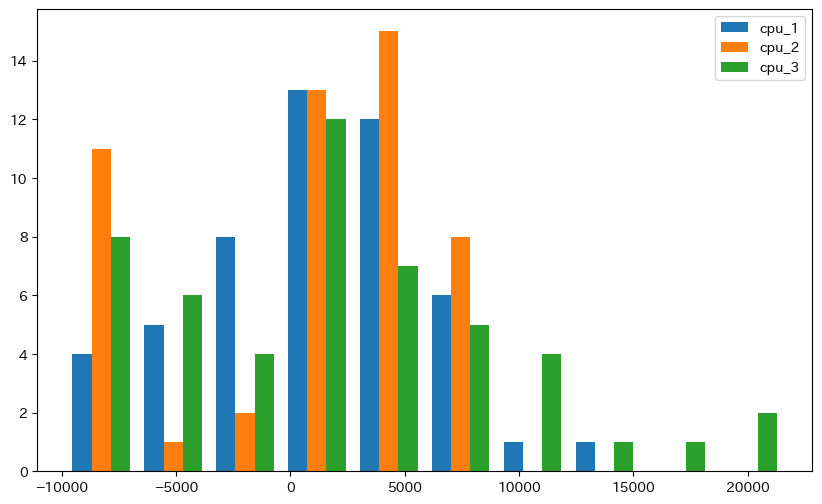

In [45]:
plt.figure(figsize=(10,6))
plt.hist(chip_result_1)
plt.legend(chip_result_1.columns)
plt.show()

In [28]:
chip_df = pd.concat([chip_df,chip_result_3])
zyoukenn_df = pd.concat([zyoukenn_df,zyoukenn_3])

In [30]:
chip_df.to_csv("300(モンテ７カウント3)chip.csv")
zyoukenn_df.to_csv("300(モンテ７カウント3)zyouken.csv")

NameError: name 'chip_df' is not defined

### 分析

In [23]:
chip_1 = pd.read_csv("データ類/300(モンテ７カウント3)chip.csv")
zyoukenn_1 = pd.read_csv("データ類/300(モンテ７カウント3)zyouken.csv")

In [25]:
display(chip_1.describe())
zyoukenn_1["session"].sum()

,cpu_1,cpu_2,cpu_3
count,300.000000,300.000000,300.000000
mean,826.596667,-80.060000,861.776667
std,7617.456591,8050.991804,10510.324891
min,-10840.000000,-10809.000000,-13986.000000
25%,-5070.000000,-8067.500000,-9623.250000
50%,754.500000,1692.500000,-615.000000
75%,5810.500000,6236.000000,8245.000000
max,27872.000000,23793.000000,46736.000000


9784

In [2]:
chip_df = pd.read_csv("賭け金ランダムchip300.csv")
zyoukenn_df = pd.read_csv("賭け金ランダムzyouken300.csv")

In [3]:
chip_df = chip_df.iloc[:,2:5]
zyoukenn_df = zyoukenn_df.iloc[:,2:5]

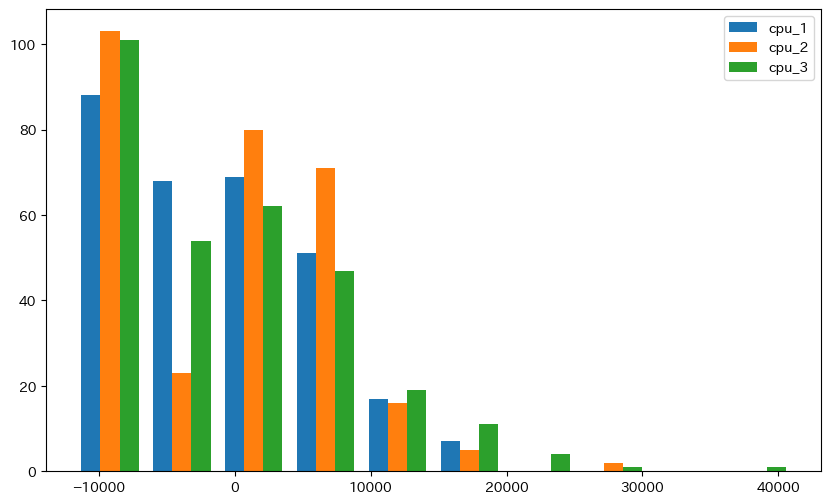

In [5]:
plt.figure(figsize=(10,6))
plt.hist(chip_df)
plt.legend(chip_df.columns)
plt.show()

In [45]:
zyoukenn_df["session"].sum()

15455

In [44]:
chip_df.describe()

,cpu_1,cpu_2,cpu_3
count,300.000000,300.000000,300.000000
mean,-910.898333,-263.120000,-745.140833
std,7160.884997,7460.294039,8738.163035
min,-11177.000000,-11210.000000,-11835.000000
25%,-8164.000000,-7989.750000,-9469.500000
50%,-1645.250000,1082.000000,-1868.000000
75%,3994.000000,5007.250000,4907.250000
max,18508.000000,26027.500000,41076.000000


In [47]:
stats.ttest_ind(chip_df["cpu_1"],chip_df["cpu_2"])

Ttest_indResult(statistic=-1.0849971783084362, pvalue=0.27836011428304885)

# 勝敗が全く同じで、賭ける金額をcpuごとに変化させた場合

In [111]:
def black_jack_threebetter(syoki_chip = 1000,deck = 2,standard_bet = 100,sesion = 20):
    #ディーラーとプレイヤーのデータフレームの用意
    df_dealer = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
    df_cpu_1 = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
    df_cpu_2 = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
    df_cpu_3 = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])

    sarender = pd.DataFrame([["heart","K"],["heart","K"],["heart","K"]],columns=["mark","num"])


    df_chip = pd.DataFrame(columns=["chip"])
    for member in range(1,4):
        cpu = pd.DataFrame([syoki_chip],index=["cpu_{}".format(member)],columns=["chip"])
        df_chip = pd.concat([df_chip,cpu])

    #カードデッキの作成
    playing_cards = cards(deck=deck)
    card_count = 0
    rest_deck = len(playing_cards) - card_count
    
    #bet金額を聞く
    bet_cpu1 = standard_bet
    bet_cpu2 = standard_bet
    bet_cpu3 = standard_bet

    #bet金額を持ちチップから減らす。
    df_chip.iloc[0] -= bet_cpu1
    df_chip.iloc[1] -= bet_cpu2
    df_chip.iloc[2] -= bet_cpu3
    
    #モンテカルロ法のセット
    monte_df = pd.DataFrame([1,2,3],columns=["count"])

    #プレイ回数をカウントする。プレイ回数が指定したセッション数を超えるとプレイが終了する。
    play_count = 0
    
    #参加するかどうか聞くデータフレーム
    join  = pd.DataFrame([1,1,1],columns=["join"],index=["cpu1","cpu2","cpu3"])

    #cpu１と２の勝利を数えるためのデータフレームを用意。負けたら０、勝ったら１、ドローなら２を記録する.
    win_log_1 = pd.DataFrame(np.zeros(500),columns=["win_flag"])
    win_log_2 = pd.DataFrame(np.zeros(500),columns=["win_flag"])
    win_log_3 = pd.DataFrame(np.zeros(500),columns=["win_flag"])

    #cpuのカウンティングと勝利を記録する
    counting_log = pd.DataFrame(columns=['log'])
    chip_log1 = pd.DataFrame(columns=["chip"])
    chip_log2 = pd.DataFrame(columns=["chip"])
    chip_log3 = pd.DataFrame(columns=["chip"])

    #プレイ開始。参加者が０になるか、前もって指定したセッション数を超えると終了する.
    while int(join.loc[join["join"] == 1].count()) >= 1 and play_count < sesion:
        if play_count == 0:
            play_count = 1
    

        #ディーラーとプレイヤーにカードを配る
        df_dealer.iloc[0] = playing_cards.iloc[card_count]
        card_count = card_count + 1


        #cpuのプレイ
        if int(join.iloc[0]) > 0 or int(join.iloc[1]) > 0 or int(join.iloc[2]) > 0:
            df_cpu_1.iloc[0] = playing_cards.iloc[card_count]
            df_cpu_2.iloc[0] = playing_cards.iloc[card_count]
            df_cpu_3.iloc[0] = playing_cards.iloc[card_count]
            card_count += 1


            df_cpu_1.iloc[1] = playing_cards.iloc[card_count]
            df_cpu_2.iloc[1] = playing_cards.iloc[card_count]
            df_cpu_3.iloc[1] = playing_cards.iloc[card_count]
            card_count += 1

            judge = 1
            num = 2
            while judge > 0:

                #現在のフィールドの情報を提供
                cpu1 = Cpu()
                cpu1.playingcpu_set(dealer=df_dealer.iloc[[0]],player = df_cpu_1)
                judge = cpu1.basic_st()


                if judge == 1:
                    #ヒットなら、cpuにカードを一枚配る
                    df_cpu_1.iloc[num] = playing_cards.iloc[card_count]
                    df_cpu_2.iloc[num] = playing_cards.iloc[card_count]
                    df_cpu_3.iloc[num] = playing_cards.iloc[card_count]
                    card_count = card_count + 1

                elif judge == 2:
                    df_chip.iloc[0] -= bet_cpu1
                    df_chip.iloc[1] -= bet_cpu2
                    df_chip.iloc[2] -= bet_cpu3
                    #ダブルダウンなら、チップからもう一度賭け金を引いて、betにbetの二倍を再代入する
                    bet_cpu1 = bet_cpu1 * 2
                    bet_cpu2 = bet_cpu2 * 2
                    bet_cpu3 = bet_cpu3 * 2

                    df_cpu_1.iloc[num] = playing_cards.iloc[card_count]
                    df_cpu_2.iloc[num] = playing_cards.iloc[card_count]
                    df_cpu_3.iloc[num] = playing_cards.iloc[card_count]
                    card_count = card_count + 1
                    judge = 0
                elif judge == 3:
                    #サレンダーしていたら、チップをベット金額の半分戻して、勝てない手札にする
                    df_chip.iloc[0] = df_chip.iloc[0] + (bet_cpu1/2)
                    df_chip.iloc[1] = df_chip.iloc[1] + (bet_cpu2/2)
                    df_chip.iloc[2] = df_chip.iloc[2] + (bet_cpu3/2)
                    df_cpu_1 = pd.concat([df_cpu_1,sarender])
                    df_cpu_2 = pd.concat([df_cpu_2,sarender])
                    df_cpu_3 = pd.concat([df_cpu_3,sarender])

                    judge = 0

                num = num + 1
                #バースト判定
                if hand_calc(df_cpu_1) >= 22:
                    judge = 0
                
                if int(join.iloc[0]) <= 0:
                    df_cpu_1 = pd.concat([df_cpu_1,sarender])
                if int(join.iloc[1]) <= 0:
                    df_cpu_2 = pd.concat([df_cpu_2,sarender])
                if int(join.iloc[2]) <= 0:
                    df_cpu_3 = pd.concat([df_cpu_3,sarender])



        #ディーラーのターン（もし全プレイヤーがバーストしてたら、その時点で終了）
        if hand_calc(df_cpu_1) < 22 or hand_calc(df_cpu_2) < 22 or hand_calc(df_cpu_3) < 22:
            num = 1
            #ディーラーの手札が合計17まで続ける
            while hand_calc(df_dealer) < 17:
                df_dealer.iloc[num] = playing_cards.iloc[card_count]
                card_count = card_count + 1
                num = num + 1

            #バーストしてなかったプレイヤーの勝利判定
            if hand_calc(df_cpu_1) < 22:
                if hand_calc(df_cpu_1) == 21 and len(df_cpu_1.loc[df_cpu_1["num"] != 0]) == 2:
                    df_chip.iloc[0] += bet_cpu1 * 2.5
                    win_log_1.iloc[play_count-1] = 21
                elif hand_calc(df_dealer) >= 22:
                    df_chip.iloc[0] += bet_cpu1 * 2
                    win_log_1.iloc[play_count-1] = 1
                elif hand_calc(df_dealer) < hand_calc(df_cpu_1):
                    df_chip.iloc[0] += bet_cpu1 * 2
                    win_log_1.iloc[play_count-1] = 1
                elif hand_calc(df_dealer) == hand_calc(df_cpu_1):
                    df_chip.iloc[0] += bet_cpu1
                    win_log_1.iloc[play_count-1] = 2

            if hand_calc(df_cpu_2) < 22:
                if hand_calc(df_cpu_2) == 21 and len(df_cpu_2.loc[df_cpu_2["num"] != 0]) == 2:
                    df_chip.iloc[1] += bet_cpu2 * 2.5
                    win_log_2.iloc[play_count-1] = 21
                elif hand_calc(df_dealer) >= 22:
                    df_chip.iloc[1] += bet_cpu2 * 2
                    win_log_2.iloc[play_count-1] = 1
                elif hand_calc(df_dealer) < hand_calc(df_cpu_2):
                    df_chip.iloc[1] += bet_cpu2 * 2
                    win_log_2.iloc[play_count-1] = 1
                elif hand_calc(df_dealer) == hand_calc(df_cpu_2):
                    df_chip.iloc[1] += bet_cpu2
                    win_log_2.iloc[play_count-1] = 2

            if hand_calc(df_cpu_3) < 22:
                if hand_calc(df_cpu_3) == 21 and len(df_cpu_3.loc[df_cpu_3["num"] != 0]) == 2:
                    df_chip.iloc[2] += bet_cpu3 * 2.5
                    win_log_3.iloc[play_count-1] = 21
                elif hand_calc(df_dealer) >= 22:
                    df_chip.iloc[2] += bet_cpu3 * 2
                    win_log_3.iloc[play_count-1] = 1
                elif hand_calc(df_dealer) < hand_calc(df_cpu_3):
                    df_chip.iloc[2] += bet_cpu3 * 2
                    win_log_3.iloc[play_count-1] = 1
                elif hand_calc(df_dealer) == hand_calc(df_cpu_3):
                    df_chip.iloc[2] += bet_cpu3
                    win_log_3.iloc[play_count-1] = 2


        bet_cpu1 = standard_bet

        #モンテカルロcpuの次のベット金額を設定する
        if int(join.iloc[1]) == 1:
            monte_carlo_cpu = Cpu()
            monte_carlo_cpu.chip_win_set(monte_table=monte_df,win_flag=int(win_log_2.iloc[play_count-1]))
            monte_df = monte_carlo_cpu.monte_carlo()
            bet_cpu2 = (int(monte_df.iloc[0]) + int(monte_df.iloc[len(monte_df) - 1])) * (standard_bet/10)
            

        #カウンティングcpuの次のベット金額を設定する
        hand_log = playing_cards.iloc[:card_count]
        counting_cpu = Cpu()
        counting_cpu.bettingcpu_set(hand_log)
        counting = counting_cpu.counting() / ((len(playing_cards)-card_count)/52)
        
        if 0 < counting <= 3:
            bet_cpu3 = standard_bet
        elif counting > 3:
            bet_cpu3 = standard_bet * 2
        elif counting <= 0:
            bet_cpu3 = standard_bet / 2

        #カウンティング状況を記録
        counting_thistime = pd.DataFrame([counting],columns=['log'])
        counting_log = pd.concat([counting_log,counting_thistime],ignore_index=True)

        #チップの推移を記録
        chip_log1 = pd.concat([chip_log1,df_chip.iloc[[0]]],ignore_index=True)
        chip_log2 = pd.concat([chip_log2,df_chip.iloc[[1]]],ignore_index=True)
        chip_log3 = pd.concat([chip_log3,df_chip.iloc[[2]]],ignore_index=True)

        #手札のリセット
        df_dealer = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
        df_cpu_1 = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
        df_cpu_2 = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
        df_cpu_3 = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])


        #山札が減っていたら補給
        rest_deck = len(playing_cards) - card_count
        if rest_deck < 15:
            playing_cards = cards(deck=deck)
            card_count = 1
            hand_log = pd.DataFrame(columns=["mark","num"])

        play_count += 1

        #もしチップが０より大きいなら、ベットさせる
        if play_count < sesion:
            if int(df_chip.iloc[0]) - bet_cpu1 >= 0:
                df_chip.iloc[0] -= bet_cpu1
                join.iloc[0] = 1
            else:
                join.iloc[0] = -3
                bet_cpu1 = 0

            if int(df_chip.iloc[1]) - bet_cpu2 >= 0:
                df_chip.iloc[1] -= bet_cpu2
                join.iloc[1] = 1
            else:
                join.iloc[1] = -3
                bet_cpu2 = 0

            if int(df_chip.iloc[2]) - bet_cpu3 >= 0:
                join.iloc[2] = 1
                df_chip.iloc[2] -= bet_cpu3
            else:
                join.iloc[2] = -3
                bet_cpu3 = 0
 
    cpu1_chip = chip_log1
    cpu1_winflag = win_log_1.iloc[:len(cpu1_chip)]
    cpu1_data = cpu1_winflag.join([cpu1_chip])
    cpu1_data.columns = (["cpu1_winlose","cpu1_chip"])
    cpu2_chip = chip_log2
    cpu2_winflag = win_log_2.iloc[:len(cpu2_chip)]
    cpu2_data = cpu2_winflag.join([cpu2_chip])
    cpu2_data.columns = (["cpu2_winlose","cpu2_chip"])
    cpu3_chip = chip_log3
    cpu3_winflag = win_log_3.iloc[:len(cpu3_chip)]
    cpu3_data = cpu3_winflag.join([cpu3_chip])
    cpu3_data.columns = (["cpu3_winlose","cpu3_chip"])
    data = cpu1_data.join([cpu2_data,cpu3_data,counting_log])
    
    return df_chip,data
    

### 一回プレイのデータを見る

,cpu1_winlose,cpu1_chip,cpu2_winlose,cpu2_chip,cpu3_winlose,cpu3_chip,log
0,0.0,9000,0.0,9000,0.0,9000,-1.560000
1,1.0,10000,1.0,9500.0,1.0,9500.0,0.559140
2,2.0,10000,2.0,9500.0,2.0,9500.0,0.000000
3,1.0,11000,1.0,10000.0,1.0,10000.0,-0.626506
4,1.0,12000,1.0,10400.0,1.0,10500.0,0.675325
5,0.0,11000,0.0,10000.0,0.0,9500.0,2.166667
6,0.0,10000,0.0,9500.0,0.0,8500.0,0.764706
7,0.0,9000,0.0,8900.0,0.0,7500.0,-1.625000
8,1.0,10000,1.0,9600.0,1.0,8000.0,0.912281
9,0.0,9000,0.0,8900.0,0.0,7000.0,-0.981132


cpu1の勝率は: 0.4897959183673469
cpu2の勝率は: 0.4897959183673469
cpu3の勝率は: 0.46938775510204084


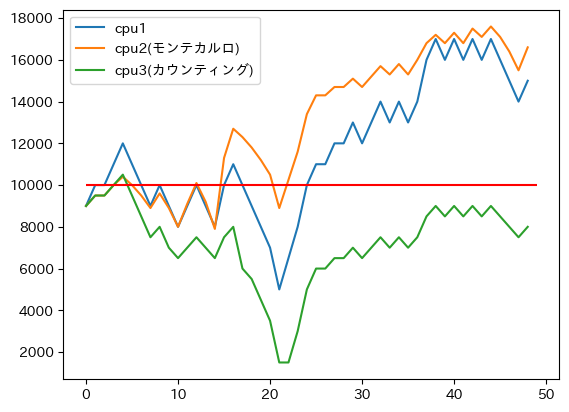

In [114]:
syoki = 10000
result = black_jack_threebetter(sesion=50,syoki_chip=syoki,standard_bet=1000)
data = result[1]
display(data)

print("cpu1の勝率は:"
,data.loc[(data["cpu1_winlose"] == 1) | (data["cpu1_winlose"] == 21)]["cpu1_winlose"].count()/len(data))
print("cpu2の勝率は:"
,data.loc[(data["cpu2_winlose"] == 1) | (data["cpu2_winlose"] == 21)]["cpu2_winlose"].count()/len(data))
print("cpu3の勝率は:"
,data.loc[(data["cpu3_winlose"] == 1) | (data["cpu3_winlose"] == 21)]["cpu3_winlose"].count()/len(data))

x = np.arange(len(data))
fig, ax = plt.subplots(facecolor="w")
ax.plot(x,data["cpu1_chip"].to_numpy() , label="cpu1")
ax.plot(x, data["cpu2_chip"].to_numpy(), label="cpu2(モンテカルロ)")
ax.plot(x,data["cpu3_chip"].to_numpy(),label = "cpu3(カウンティング)")
plt.hlines(syoki,0,len(data),colors="red")
ax.legend()
plt.show()

### 何回かプレイさせて、そのチップの推移を出力する

0回目


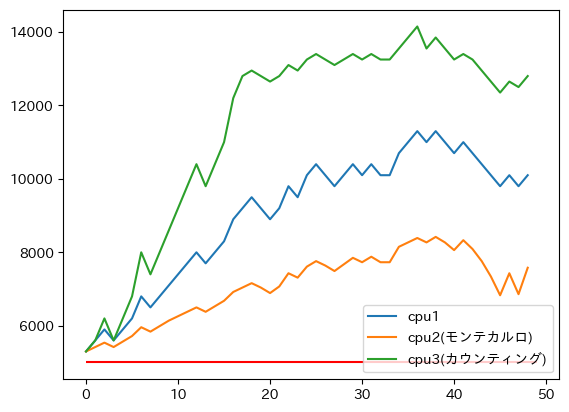

cpu1の勝率は: 0.6122448979591837
cpu2の勝率は: 0.6122448979591837
cpu3の勝率は: 0.6122448979591837


,max-min
gamble_cpu3,8850.0


1回目


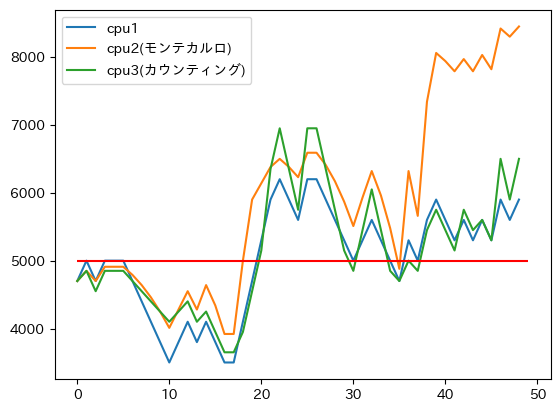

cpu1の勝率は: 0.40816326530612246
cpu2の勝率は: 0.40816326530612246
cpu3の勝率は: 0.40816326530612246


,max-min
gamble_cpu2,4530.0


2回目


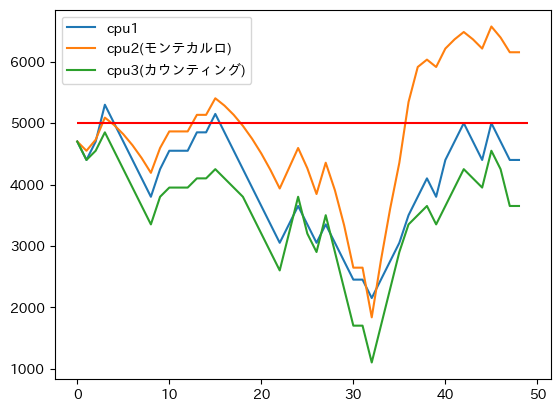

cpu1の勝率は: 0.3877551020408163
cpu2の勝率は: 0.3877551020408163
cpu3の勝率は: 0.3877551020408163


,max-min
gamble_cpu2,4740.0


In [116]:
for i in range(3):
    syoki = 5000
    print("{}回目".format(i))
    result = black_jack_threebetter(sesion=50,syoki_chip=syoki,standard_bet=300)
    data = result[1]

    x = np.arange(len(data))
    fig, ax = plt.subplots(facecolor="w")
    ax.plot(x,data["cpu1_chip"].to_numpy() , label="cpu1")
    ax.plot(x, data["cpu2_chip"].to_numpy(), label="cpu2(モンテカルロ)")
    ax.plot(x,data["cpu3_chip"].to_numpy(),label = "cpu3(カウンティング)")
    plt.hlines(syoki,0,len(data),colors="red")
    ax.legend()
    plt.show()
    print("cpu1の勝率は:"
    ,data.loc[(data["cpu1_winlose"] == 1) | (data["cpu1_winlose"] == 21)]["cpu1_winlose"].count()/len(data))
    print("cpu2の勝率は:"
    ,data.loc[(data["cpu2_winlose"] == 1) | (data["cpu2_winlose"] == 21)]["cpu2_winlose"].count()/len(data))
    print("cpu3の勝率は:"
    ,data.loc[(data["cpu3_winlose"] == 1) | (data["cpu3_winlose"] == 21)]["cpu3_winlose"].count()/len(data))
    #最もギャンブル性が高いcpuを出力する  
    gamble_cpu1 = data["cpu1_chip"].max() - data["cpu1_chip"].min()
    gamble_cpu2 = data["cpu2_chip"].max() - data["cpu2_chip"].min()
    gamble_cpu3 = data["cpu3_chip"].max() - data["cpu3_chip"].min()
    df = pd.DataFrame([gamble_cpu1,gamble_cpu2,gamble_cpu3],index=["gamble_cpu1","gamble_cpu2","gamble_cpu3"],columns=["max-min"])
    display(df.sort_values(by=["max-min"],ascending=False).iloc[[0]])

### 何回かプレイさせて、その勝ち額を出力する

In [21]:
i = 0
int(chip["cpu_{}".format(i + 1)]) > 0

True

In [50]:
#最初に持っているお金と、かけるお金にランダム性を持たせて観測を行う。
for i in range(1):
    if i  == 0:
        chip_result = pd.DataFrame(columns = ["cpu_1","cpu_2","cpu_3"])
        zyoukenn = pd.DataFrame(columns= ["syoki_chip","standardbet","session"])
        
    syoki = int(abs(np.random.normal(loc=10000,scale=2500)))
    standard = int(abs(np.random.normal(loc=1000,scale=250)))
    session = int(abs(np.random.normal(loc = 50,scale=20)))


    result = black_jack_threebetter(syoki_chip=syoki,standard_bet=standard,sesion=session)
    
    chip_thistime = result[0].transpose() - syoki
    chip_thistime = chip_thistime.rename(index={"chip" : "{}回目勝ち額".format(i+1)})
    zyoukenn_thistime = pd.DataFrame({"syoki_chip": [syoki], "standardbet": [standard], "session": [session]},index=["{}回目".format(i + 1)])



    zyoukenn = pd.concat([zyoukenn,zyoukenn_thistime])
    chip_result = pd.concat([chip_result,chip_thistime])


chip_result = chip_result.astype(int)
zyoukenn = zyoukenn.astype(int)

In [51]:
display(chip_result.describe())
display(zyoukenn.head())

,cpu_1,cpu_2,cpu_3
count,1.0,1.0,1.0
mean,-1558.0,3583.0,2726.0
std,NaN,NaN,NaN
min,-1558.0,3583.0,2726.0
25%,-1558.0,3583.0,2726.0
50%,-1558.0,3583.0,2726.0
75%,-1558.0,3583.0,2726.0
max,-1558.0,3583.0,2726.0


,syoki_chip,standardbet,session
1回目,11753,1558,19


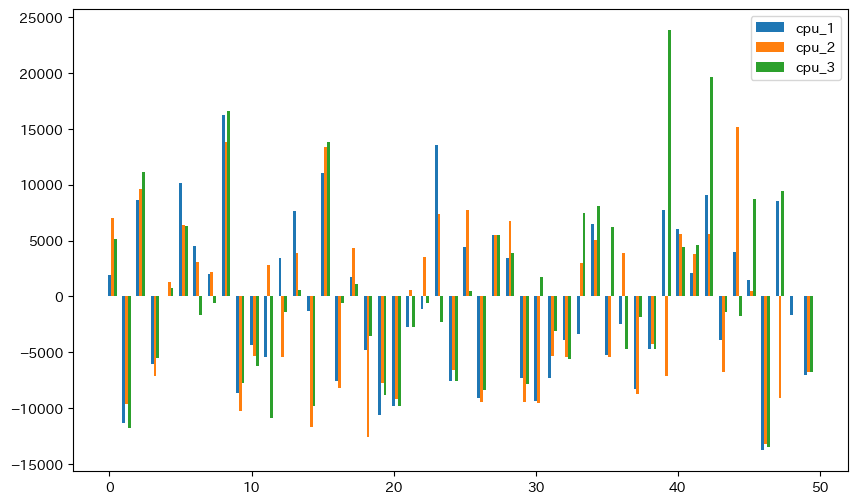

In [46]:
x = np.arange(len(chip_result))

width = 0.2 
plt.figure(figsize=(10,6))

plt.bar(x,chip_result["cpu_1"],width=width,align="center")
plt.bar(x + width,chip_result["cpu_2"],width=width,align="center")
plt.bar(x + width*2,chip_result["cpu_3"],width=width,align="center")
plt.legend(chip_result.columns)
plt.show()

In [47]:
new_chip = pd.concat([chip_df,chip_result])
new_zyouken = pd.concat([zyoukenn_df,zyoukenn])

In [48]:
new_chip.to_csv("chip500.csv")
new_zyouken.to_csv("zyoukenn500.csv")

## 分析

In [5]:
sc =StandardScaler()

chip_df = pd.read_csv("chip500.csv")
zyoukenn_df = pd.read_csv("zyoukenn500.csv")

In [6]:
chip_df = chip_df.iloc[:,9:13]
zyoukenn_df = zyoukenn_df.iloc[:,9:13]

In [7]:
display(chip_df.head())
display(zyoukenn_df.head())

,cpu_1,cpu_2,cpu_3
0,-1264,-16438,1896
1,-9381,-9931,-10190
2,942,3956,2198
3,1537,2921,-1281
4,14145,11693,18624


,syoki_chip,standardbet,session
0,17823,843,59
1,11252,647,49
2,10678,628,62
3,9745,1025,32
4,11852,943,65


In [8]:
chip_df.describe()

,cpu_1,cpu_2,cpu_3
count,500.000000,500.000000,500.000000
mean,23.574000,213.776000,403.122000
std,7361.001752,7418.819397,7848.267559
min,-14365.000000,-16438.000000,-16360.000000
25%,-5840.000000,-6894.250000,-5410.250000
50%,0.000000,1861.000000,0.000000
75%,4928.750000,5557.750000,5511.000000
max,25203.000000,18577.000000,40650.000000


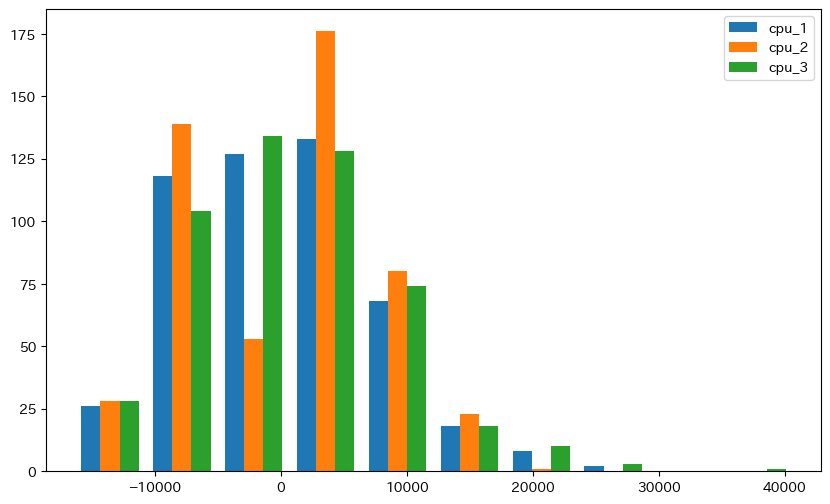

In [11]:
plt.figure(figsize=(10,6))
plt.hist(chip_df)
plt.legend(chip_df.columns)
plt.show()

In [8]:
zyoukenn_scaled = pd.DataFrame(sc.fit_transform(zyoukenn_df),columns=zyoukenn_df.columns)
zyoukenn_scaled.describe()

,syoki_chip,standardbet,session,wariai
count,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02
mean,-2.642331e-16,1.332268e-16,-1.665335e-16,5.773160e-17
std,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00
min,-3.160376e+00,-2.857442e+00,-2.529708e+00,-1.940570e+00
25%,-7.571340e-01,-6.778700e-01,-7.281049e-01,-6.017577e-01
50%,5.331216e-02,3.478040e-04,-3.320097e-02,-1.148521e-01
75%,7.245618e-01,5.945130e-01,6.745716e-01,3.886015e-01
max,2.910847e+00,2.800170e+00,2.566255e+00,5.393160e+00


In [9]:
df1 = zyoukenn_scaled.join(chip_df["cpu_1"])
df2 = zyoukenn_scaled.join(chip_df["cpu_2"])
df3 = zyoukenn_scaled.join(chip_df["cpu_3"])

<AxesSubplot: >

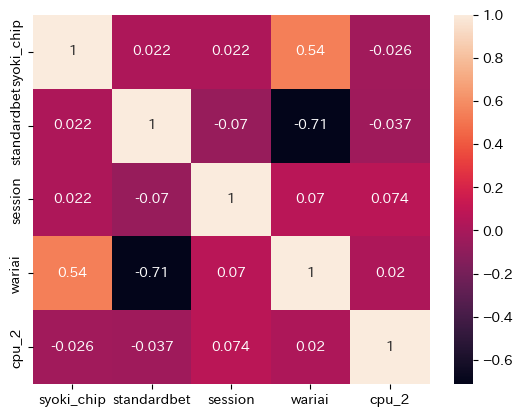

In [10]:
import seaborn as sns

sns.heatmap(df2.corr(),annot=True)

# ルーレットをしよう

In [1]:
import pandas as pd
import numpy as np

In [19]:
def roulette(session = 20,syoki = 2000,standard_bet = 10):
    #最適なベット戦略を考察するためのプログラム。後述するモンテカルロ法で
    #どのくらいの倍率で賭ければ最終的に収支を上げることができるのかをシミュレートする。

    #データの初期化と必要なデータフレームの用意
    play_count = 1
    win_log = pd.DataFrame(np.zeros(200),columns=["win_lose"])
    chip_df = pd.DataFrame([syoki],columns=["chip"])
    bet = 4 * standard_bet
    cpu = Cpu()
    monte_df = pd.DataFrame([1,2,3],columns=["count"])
    join = 1
    #プレイ開始。プレイヤーのチップがなくなるか指定された数を超えるまでプレイを続ける。
    while play_count < session + 1 and join == 1:
        #ルーレットを回す。37と０はそれぞれグリーンを出力し、２の倍数ならブラックを出力する。それ以外ならレッド。
        number = np.random.randint(0,37)
        if number == 0:
            col = "green"
        elif number == 37:
            col = "green"
        elif number % 2 == 0:
            col = "black"
        else:
            col = "red"
        output = pd.DataFrame([[number,col]],columns=("number","col"))


        #今回の分析はルーレットのブラックにベットし続けることを想定している。そのため、ブラックが出たら当たりと判定する。
        if output["col"].iloc[-1] == "black":
            win_log.iloc[play_count-1] = 1
            chip_df["chip"] += bet * 2

            cpu.chip_win_set(monte_df,win_flag=int(win_log.iloc[play_count-1]))
            monte_df = cpu.monte_carlo()
        else:
            cpu.chip_win_set(monte_df,win_flag=int(win_log.iloc[play_count-1]))
            monte_df = cpu.monte_carlo()

        #モンテカルロ法（負けたら次の賭け金を増やす、勝ったら次の賭け金を減らす）というアルゴリズムでベットする金額を変える。
        bet = (int(monte_df.iloc[0]) + int(monte_df.iloc[len(monte_df) - 1])) * (standard_bet)
        chip_df-= bet
        play_count += 1
        if chip_df["chip"].iloc[-1] - bet > 0:
            join = 1
        else:
            join = 0
        
    win_log = win_log.iloc[:play_count - 1]

    #最終的に持っていたチップと勝率を出力する。
    return chip_df, win_log


In [20]:
syoki_chip = 2000
result = roulette(syoki=syoki_chip,standard_bet = 100,session=30)
display(result[0] - syoki_chip)
display(result[1])

len(result[1])

,chip
0,7700


,win_lose
0,0.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,0.0
7,1.0
8,1.0
9,0.0


30

In [223]:
game_num = 10000
syoki = 2000
for i in range(game_num):
    clear_output()
    if i  == 0:
        chip_log = pd.DataFrame(columns=["chip","st"])
        win_rate = pd.DataFrame(np.zeros(game_num),columns=["win_lose"],index=np.arange(game_num))
    se = int(np.random.normal(30,5))
    st = np.random.randint(1,40)
    this_time = roulette(session=se,standard_bet=st,syoki=syoki)
    chip_thistime = this_time[0] - syoki
    chip_log = pd.concat([chip_log,chip_thistime])
    chip_log["st"].iloc[i] = st

    win_this_time = this_time[1]
    rate_thistime = win_this_time.sum() / len(win_this_time)
    win_rate.iloc[i] = rate_thistime

    print("{}回目".format(i+1))


chip_log = chip_log.reset_index(drop=True)
display(chip_log.head())
display(win_rate.head())

10000回目


,chip,st
0,403,31
1,-288,12
2,-1716,39
3,575,25
4,-1554,37


,win_lose
0,0.548387
1,0.407407
2,0.300000
3,0.600000
4,0.461538


In [224]:
chip_log.loc[chip_log["st"] == 2].astype(int).describe()

,chip,st
count,278.000000,278.0
mean,-38.611511,2.0
std,189.726043,0.0
min,-1280.000000,2.0
25%,-47.500000,2.0
50%,16.000000,2.0
75%,52.000000,2.0
max,134.000000,2.0


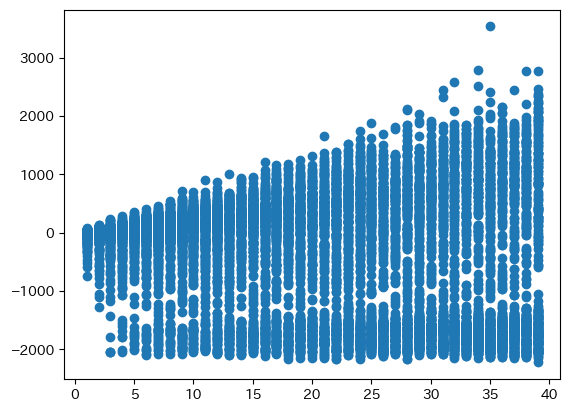

In [225]:
plt.scatter(chip_log["st"],chip_log["chip"])
plt.show()

In [226]:
for i in range(40):
    if i == 0:
        chip_mean = pd.DataFrame(np.zeros(40),columns=["mean"])
    
    chip_mean.iloc[i] = chip_log.loc[chip_log["st"] == i].astype(int).describe().iloc[5,0]#各スタンダードベッドの50％分位点を入れる

In [227]:
chip_mean.head()

,mean
0,NaN
1,7.0
2,16.0
3,24.0
4,22.0


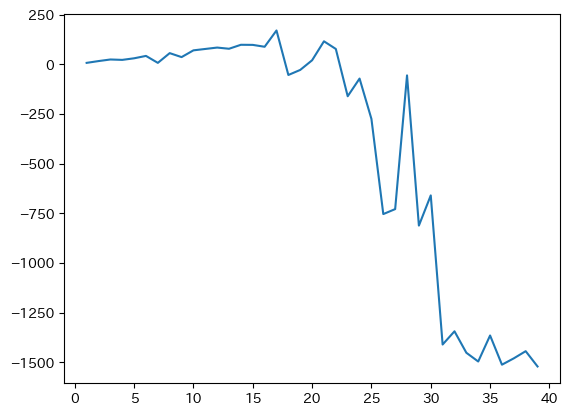

In [228]:
plt.plot(np.arange(len(chip_mean)),chip_mean)

In [229]:
chip_mean_3 = chip_mean
win_rate_3 = win_rate

In [230]:
csv_chip = pd.concat([csv_chip,chip_mean_3])
csv_winrate = pd.concat([csv_winrate,win_rate_3])

In [231]:
csv_chip.to_csv("ルーレット30000改良ちっぷ.csv")
csv_winrate.to_csv("ルーレット30000改良レート.csv")

### 分析

In [26]:
df = pd.read_csv("ルーレット50000chip.csv")
del df["Unnamed: 0"]
df.head()

,chip,st
0,-1653,29
1,252,12
2,368,8
3,688,16
4,-34,17


In [27]:
df.describe()

,chip,st
count,50000.000000,50000.00000
mean,-165.469960,20.05946
std,1033.133628,11.23855
min,-2244.000000,1.00000
25%,-1121.000000,10.00000
50%,78.000000,20.00000
75%,504.000000,30.00000
max,3914.000000,39.00000


In [33]:
df.loc[df["st"] == 22].astype(int).describe()

,chip,st
count,1276.000000,1276.0
mean,-165.189655,22.0
std,1090.150443,0.0
min,-2178.000000,22.0
25%,-1518.000000,22.0
50%,264.000000,22.0
75%,682.000000,22.0
max,2134.000000,22.0


In [42]:
for i in range(40):
    if i == 0:
        chip_median = pd.DataFrame(np.zeros(40),columns=["median"])
    
    chip_median.iloc[i] = df.loc[df["st"] == i].astype(int).describe().iloc[5,0]

In [43]:
chip_median.head()

,median
0,NaN
1,14.0
2,30.0
3,42.0
4,56.0


In [44]:
chip_median.describe()

,median
count,39.000000
mean,69.089744
std,196.160778
min,-499.500000
25%,32.000000
50%,117.000000
75%,198.000000
max,270.000000


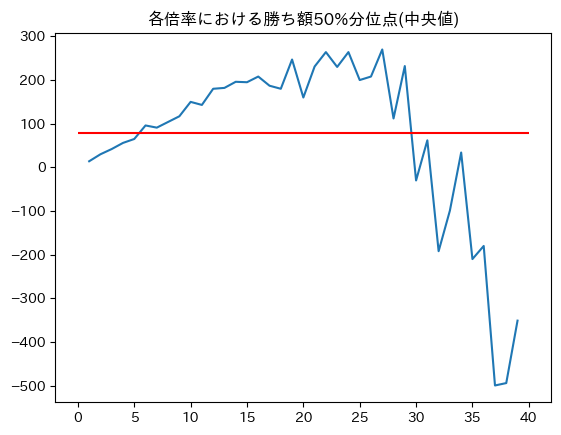

In [45]:
plt.plot(np.arange(len(chip_median)),chip_median)
plt.title("各倍率における勝ち額50%分位点(中央値)")
plt.hlines(y = df.describe().iloc[5,0],xmax=0,xmin=40,colors="red")#全体の50%分位点
plt.show()

In [95]:
chip_median.iloc[20:30]#中央値ができるだけ大きく、分散ができるだけ小さい倍率が最も良いという点で合理的な倍率は22倍でありそうだと結論づけられる。

,median
20,160.0
21,231.0
22,264.0
23,230.0
24,264.0
25,200.0
26,208.0
27,270.0
28,112.0
29,232.0


In [93]:
df.loc[df["st"] == 22].astype(int).describe()

,chip,st
count,1276.000000,1276.0
mean,-165.189655,22.0
std,1090.150443,0.0
min,-2178.000000,22.0
25%,-1518.000000,22.0
50%,264.000000,22.0
75%,682.000000,22.0
max,2134.000000,22.0


In [30]:
df.loc[df["st"] == 22].astype(int).quantile(0.57)

chip    396.0
st       22.0
Name: 0.57, dtype: float64

In [9]:
df.describe()

,chip,st
count,50000.000000,50000.00000
mean,-165.469960,20.05946
std,1033.133628,11.23855
min,-2244.000000,1.00000
25%,-1121.000000,10.00000
50%,78.000000,20.00000
75%,504.000000,30.00000
max,3914.000000,39.00000


In [1]:
def print_sqare(start,stop):
    for i in range(stop):
        print((start + i) ** 2)

# 蛇足

In [ ]:
class Black_jack():
    def cards(self,deck = 2) -> pd.DataFrame:
        #カードをシャッフルする関数
        
        cards_df = pd.DataFrame(np.zeros(deck * 104).reshape(deck * 52,2),columns=["mark","num"])
        cards_number = ["A","2","3","4","5","6","7","8","9","10","J","Q","K"] * 4 * deck
        cards_mark = ["heart","spade","clob","diamond"] * 13 * deck

        #デッキの数分マークとナンバーを入れる
        for i in range(52 * deck):
            cards_df.iloc[i] = cards_mark[i]
            cards_df["num"].iloc[i] = cards_number[i]

        cards = cards_df.sample(n =len(cards_df))
        self.deck = cards.reset_index(drop=True)

        return self.deck
            

    

    def hand_calc(self,hand) -> int:
        #今の手札の合計を数える関数
        hand_df = hand.loc[hand["num"] != 0][["num"]]
        #まずはナンバーと、ピクチャーと、エースの分類を分ける
        number = ["2","3","4","5","6","7","8","9","10"]
        picture = ["J","Q","K"]
        Ace = ["A"]

        #ピクチャーを10に置き換えて、合計
        picture_hand = hand_df.loc[hand_df["num"].isin(picture)].copy()
        for pict in range(len(picture_hand)):
            picture_hand.iloc[pict] = 10
        picture_hand_int = picture_hand.sum()

        #ナンバーをそのままint型へ変えて、合計
        int_hand = hand_df.loc[hand_df["num"].isin(number)].astype(int).sum()

        #ナンバーとピクチャーの合計をとる
        hand = picture_hand_int + int_hand
        hand = int(hand)

        #エースの処理

        #エースが最大の時と最小で比較する
        Ace_hand = hand_df.loc[hand_df["num"].isin(Ace)].copy()
        Ace_max = Ace_hand.count() * 11 + hand
        Ace_min = Ace_hand.count() * 1 + hand

        #エースを最大としてとったらバーストするが、最小としてとったらバーストしない場合にエースを処理する
        for a in range(len(Ace_hand)):
            Ace_hand.iloc[a] = 11

        if Ace_max.iloc[0] > 21 and Ace_min.iloc[0] <= 21:
            num = 0
            while Ace_max.iloc[0] > 21:
                Ace_hand.iloc[num] = 1
                Ace_max = Ace_hand.sum() + hand
                num = num + 1


        self.hand_sum = Ace_max.iloc[0]
        
    class Cpu():
        def playingcpu_set(self,dealer,player):
            self.dealer = dealer
            self.player = player

        def bettingcpu_set(self,field):
            self.field = field

        def chip_win_set(self,monte_table,win_flag):
            self.winflag = win_flag
            self.monte_table = monte_table

        def monte_carlo(self) -> pd.DataFrame:
            #モンテカルロ法メソッド
            win_flag = self.winflag
            all_chip  = self.monte_table
            start = 0
            last = len(all_chip)-1

            if win_flag == 0:
                next_chip = pd.DataFrame([int(all_chip.iloc[start]) + int(all_chip.iloc[last])],columns=["count"])
                all_chip = pd.concat([all_chip,next_chip],ignore_index=True)
                
            elif win_flag == 1 or win_flag == 21:
                all_chip.drop([start,last],inplace = True)
                all_chip = all_chip.reset_index(drop = True)

                if len(all_chip) <= 1:
                    all_chip = pd.DataFrame([1,2,3],columns=["count"])


            return all_chip


        def counting(self) -> int:
            #フィールド上で今まで出てきたカードを数えるメソッド
            field = self.field
            new_hand_log = field[["num"]].copy()

            #フィールド上のカードを全て数字に置き換える
            for i in range(len(field)):
                hand_num = hand_calc(field.iloc[[i]])
                new_hand_log.iloc[i] = hand_num
            
            high_hand = new_hand_log.loc[new_hand_log["num"] >= 10]
            mid_hand = new_hand_log.loc[(new_hand_log["num"] >= 7)&(new_hand_log["num"] <=9)]
            low_hand = new_hand_log.loc[new_hand_log["num"]  <= 6]

            counting = (high_hand.count() * (-1)) + low_hand.count()
            counting = counting.iloc[-1]
            
            return counting



        def basic_st(self) -> int:
            #ベーシックストラテジーのメソッド
            cpu_df = self.player
            cpu_df = cpu_df.loc[cpu_df["num"] != 0][["num"]]
            cpu_calc = hand_calc(cpu_df)

            dealer_df = self.dealer
            dealer_df = dealer_df.loc[dealer_df["num"] != 0][["num"]]
            dealer_calc = hand_calc(dealer_df)


            #ソフトハンド
            if cpu_df.isin(["A"]).any().bool() and len(cpu_df) == 2:
                if cpu_calc >= 19:
                    judge = 0
                elif cpu_calc == 18 and dealer_calc == 2:
                    judge = 0
                elif cpu_calc == 18 and 7 <= dealer_calc <= 8:
                    judge = 0

                elif cpu_calc == 18 and 3 <= dealer_calc <= 4:
                    judge = 2
                elif cpu_calc == 17 and 3 <= dealer_calc <= 4:
                    judge = 2
                elif 15 <= cpu_calc <= 16 and dealer_calc == 4:
                    judge = 2
                elif 13 <= cpu_calc <= 18 and 5 <= dealer_calc <= 6:
                    judge = 2
                    
                elif cpu_calc == 18 and 9 <= dealer_calc <= 11:
                    judge = 1
                elif cpu_calc == 17 and dealer_calc == 2:
                    judge = 1
                elif 13 <= cpu_calc <= 16 and 2 <= dealer_calc <= 3:
                    judge = 1
                elif 13 <= cpu_calc <= 14 and dealer_calc == 4:
                    judge = 1
                elif 13 <= cpu_calc <= 17 and 7 <= dealer_calc <= 11:
                    judge = 1

                #今回はダブルスプリット未実装のため、もしAAの時は実質的にハードハンド
                elif cpu_calc == 12 and 2 <= dealer_calc <= 3:
                    judge = 1
                elif cpu_calc == 12 and 4 <= dealer_calc <= 6:
                    judge = 0
                elif cpu_calc == 12 and 7 <= dealer_calc <= 11:
                    judge = 1
                    
            #ハードハンド
            else:
                if cpu_calc <= 8:
                    judge = 1
                elif cpu_calc == 9 and dealer_calc == 2:
                    judge = 1
                elif cpu_calc == 9 and 7 <= dealer_calc <= 11:
                    judge = 1
                elif cpu_calc == 10 and 10 <= dealer_calc <= 11:
                    judge = 1
                elif cpu_calc == 11 and dealer_calc == 11:
                    judge = 1

                elif 9 <= cpu_calc <= 11 and 3 <= dealer_calc <= 6:
                    judge = 2
                elif 10 <= cpu_calc <= 11 and 7 <= dealer_calc <= 9:
                    judge  = 2
                elif cpu_calc == 11 and dealer_calc ==10:
                    judge = 2
                elif 10 <= cpu_calc <= 11 and dealer_calc == 2:
                    judge = 2

                elif cpu_calc == 12 and dealer_calc >= 7:
                    judge = 1
                elif cpu_calc == 12 and 4 <= dealer_calc <= 6:
                    judge = 0
                elif cpu_calc == 12 and dealer_calc <= 3:
                    judge = 1
                
                elif 13  <= cpu_calc <= 14 and 7 <= dealer_calc <= 11:
                    judge = 1
                elif 15 <= cpu_calc <= 16 and 7 <= dealer_calc <= 8:
                    judge = 1
                elif cpu_calc == 15 and dealer_calc == 9:
                    judge = 1
                elif cpu_calc == 15 and dealer_calc == 11:
                    judge = 1

                elif cpu_calc == 15 and dealer_calc == 10:
                    judge = 1
                elif cpu_calc == 16 and 9 <= dealer_calc  <= 11:
                    judge = 1
                elif 13 <= cpu_calc <= 16 and 2 <= dealer_calc <= 6:
                    judge = 0
                elif 15 <= cpu_calc <= 16 and 7 <= dealer_calc <= 8:
                    judge = 1
                elif cpu_calc >= 17:
                    judge = 0

            return judge
        

        def high_count_st(self):
            #トゥルーカウントが高い時のメソッド
            cpu_df = self.player
            cpu_df = cpu_df.loc[cpu_df["num"] != 0][["num"]]
            cpu_calc = hand_calc(cpu_df)

            dealer_df = self.dealer
            dealer_df = dealer_df.loc[dealer_df["num"] != 0][["num"]]
            dealer_calc = hand_calc(dealer_df)

            if cpu_df.isin(["A"]).any().bool() and len(cpu_df) == 2:
                #ソフトハンド
                if cpu_calc >= 20:
                    judge = 0
                elif cpu_calc == 19 and 2 <= dealer_calc <= 3:
                    judge = 0
                elif cpu_calc == 19 and 4 <= dealer_calc <= 6:
                    judge = 2
                elif cpu_calc == 19 and 7 <= dealer_calc <= 11:
                    judge = 0
                elif 17 <= cpu_calc <= 18 and 2 <= dealer_calc <= 6:
                    judge = 2
                elif cpu_calc == 18 and 7 <= dealer_calc <= 8:
                    judge = 0
                elif cpu_calc == 18 and 9 <= dealer_calc <= 10:
                    judge = 1
                elif cpu_calc == 18 and dealer_calc == 11:
                    judge = 0
                elif 13 <= cpu_calc <= 16 and dealer_calc == 2:
                    judge = 1
                elif 13 <= cpu_calc <= 15 and dealer_calc == 3:
                    judge = 1
                elif cpu_calc == 16 and dealer_calc == 3:
                    judge = 2
                elif 13 <= cpu_calc <= 16 and 4 <= dealer_calc <= 6:
                    judge = 2
                elif 13 <= cpu_calc <= 17 and 7 <= dealer_calc <= 11:
                    judge = 1

                #ダブルスプリット未実装のため、AAはハードハンドとして扱う
                elif cpu_calc == 12 and 2 <= dealer_calc <= 6:
                    judge = 0
                elif cpu_calc == 12 and 7 <= dealer_calc <= 11:
                    judge = 1
            else:
                #ハードハンド
                if cpu_calc <= 7:
                    judge = 1
                elif cpu_calc == 8 and 2 <= dealer_calc <= 4:
                    judge = 1
                elif cpu_calc == 8 and 5 <= dealer_calc <= 6:
                    judge = 2
                elif cpu_calc == 8 and 7 <= dealer_calc <= 11:
                    judge = 1
                elif 9 <= cpu_calc <= 11 and 2 <= dealer_calc <= 7:
                    judge = 2
                elif cpu_calc == 9 and 8 <= dealer_calc <= 11:
                    judge = 1
                elif 10 <= cpu_calc <= 11 and 8 <= dealer_calc <= 9:
                    judge = 2
                elif cpu_calc == 10 and 10 <= dealer_calc <= 11:
                    judge = 1
                elif cpu_calc == 11 and 10 <= dealer_calc <= 11:
                    judge = 2
                elif 12 <= cpu_calc <= 16 and 2 <= dealer_calc <= 6:
                    judge = 0
                elif 12 <= cpu_calc <= 16 and 7 <= dealer_calc <= 9:
                    judge = 1
                elif 12 <= cpu_calc <= 14 and 10 <= dealer_calc <= 11:
                    judge = 1
                elif 15 <= cpu_calc <= 16 and dealer_calc == 10:
                    judge = 0
                elif 15 <= cpu_calc <= 16 and dealer_calc == 11:
                    judge = 1
                elif cpu_calc >= 17:
                    judge = 0

            return judge
    



    def black_jack(self,syoki_chip = 1000,deck = 2):
    #ディーラーとプレイヤーのデータフレームの用意
        df_dealer = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
        df_player = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
        hand_log = pd.DataFrame(columns=["mark","num"])
        df_chip = pd.DataFrame([syoki_chip],index=["player"],columns=["chip"])


        #カードデッキの作成
        playing_cards = self.cards(deck = deck)
        card_count = 0
        rest_deck = len(playing_cards) - card_count
        sarender = pd.DataFrame([["heart","K"],["heart","K"],["heart","K"]],columns=["mark","num"])
        
        #bet金額を聞く
        bet = input("いくらかけますか？今{}です。".format(df_chip.iloc[0]))
        bet = int(bet)
        chip_sum = df_chip.sum().iloc[-1]


        while chip_sum > 0 and rest_deck > 10:
            df_chip.iloc[0] = df_chip.iloc[0] - bet
            
            #ディーラーとプレイヤーにカードを配る
            df_dealer.iloc[0] = playing_cards.iloc[card_count]
            hand_log = pd.concat([hand_log,playing_cards.iloc[[card_count]]])
            card_count = card_count + 1

            df_player.iloc[0] = playing_cards.iloc[card_count]
            hand_log = pd.concat([hand_log,playing_cards.iloc[[card_count]]])
            card_count = card_count + 1

            df_player.iloc[1] = playing_cards.iloc[card_count]
            hand_log = pd.concat([hand_log,playing_cards.iloc[[card_count]]])
            card_count = card_count + 1

            judge = 1
            num = 2
            #プレイヤーのジャッジが１より大きい間継続
            while judge > 0:

                #現在のフィールドの情報を提供
                display("ディーラーのハンドは:",df_dealer.iloc[[0]])
                display("あなたのハンドは:",df_player.loc[df_player["num"] != 0])

                print("現在ディーラーは",self.hand_calc(df_dealer),"現在あなたは",self.hand_calc(df_player))
                
                #プレイヤーにヒットするかどうか判断させる
                judge = int(input("ヒットなら1、ダブルダウンは2、サレンダーは3表示されてなかったら10,スタンドなら0。(ダブルダウンの場合の残りチップ{})".format(df_chip.iloc[0]-bet)))

                if judge == 1:
                    #ヒットなら、プレイヤーにカードを一枚配る
                    df_player.iloc[num] = playing_cards.iloc[card_count]
                    hand_log = pd.concat([hand_log,playing_cards.iloc[[card_count]]])
                    card_count = card_count + 1

                elif judge == 2:
                    df_chip.iloc[0] = df_chip.iloc[0] - bet
                    #ダブルダウンなら、チップからもう一度賭け金を引いて、betにbetの二倍を再代入する
                    bet = bet * 2
                    df_player.iloc[num] = playing_cards.iloc[card_count]
                    hand_log = pd.concat([hand_log,playing_cards.iloc[[card_count]]])
                    card_count = card_count + 1
                    judge = 0
                elif judge == 3:
                    df_chip.iloc[0] = df_chip.iloc[0] + (bet/2)
                    df_player = pd.concat([df_player,sarender])
                    judge = 0
                elif judge == 10:
                    #うまく表示できなかった時に、フィールド情報を再表示する
                    print("現在ディーラーは",self.hand_calc(df_dealer),"現在あなたは",self.hand_calc(df_player))
                num = num + 1

                clear_output()
                #バースト判定
                if self.hand_calc(df_player) >= 22:
                    print("バーストしました")
                    judge = 0


            #ディーラーのターン（もしプレイヤーがバーストしてたら、その時点で終了）
            if self.hand_calc(df_player) < 22:
                num = 1
                #ディーラーの手札が合計17まで続ける
                while self.hand_calc(df_dealer) < 17:
                    df_dealer.iloc[num] = playing_cards.iloc[card_count]
                    hand_log = pd.concat([hand_log,playing_cards.iloc[[card_count]]])
                    card_count = card_count + 1

                    print("現在ディーラーは",self.hand_calc(df_dealer),"現在あなたは",self.hand_calc(df_player))
                    num = num + 1

                #勝敗判定
                if self.hand_calc(df_dealer) > 21:
                    print("you win")
                    df_chip.iloc[0] = df_chip.iloc[0] + bet * 2
                elif self.hand_calc(df_dealer) - self.hand_calc(df_player) > 0:
                    print("you lost")

                elif self.hand_calc(df_dealer) - self.hand_calc(df_player) <= 0:
                    print("you win")
                    df_chip.iloc[0] = df_chip.iloc[0] + bet * 2

            df_dealer = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])
            df_player = pd.DataFrame(np.zeros(20).reshape(10,2),columns=["mark","num"])


            bet = input("いくらかけますか？今{}です。終了したい場合はfinを入力してください。".format(df_chip.iloc[0]))
            if bet == "fin":
                break
            bet = int(bet)
            chip_sum = df_chip.sum().iloc[-1]
            rest_deck = len(playing_cards) - card_count
        return df_chip
            